# Analysis of Diaz2019 E9.5 mouse embryo data

Before proceeding, download the inDrops counts tables here:<br>
https://kleintools.hms.harvard.edu/paper_websites/diaz_2019/Diaz2019_inDropsCountsTables.zip

Check out our web portal for fully analyzed interactive versions of the single-cell data: <br>
https://tinyurl.com/DiazPourquie2019

### Import Packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import scipy.sparse
import scrublet as scr
import os
import sys
import pickle

sys.path.append('../')
import helper_functions_dew as dew

In [2]:
# ScanPy settings
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=120, dpi_save=600, vector_friendly=False)  
sc.logging.print_versions()

# Matplotlib settings
plt.rcParams['pdf.fonttype']=42  # Necessary to export text (rather than curves) in pdf files

scanpy==1.4.3 anndata==0.6.19 umap==0.3.8 numpy==1.16.2 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


### Import Libraries

_________________ OP010
Loading from npz file
(5763, 40523) 

_________________ OP011
Loading from npz file
(4652, 40523) 



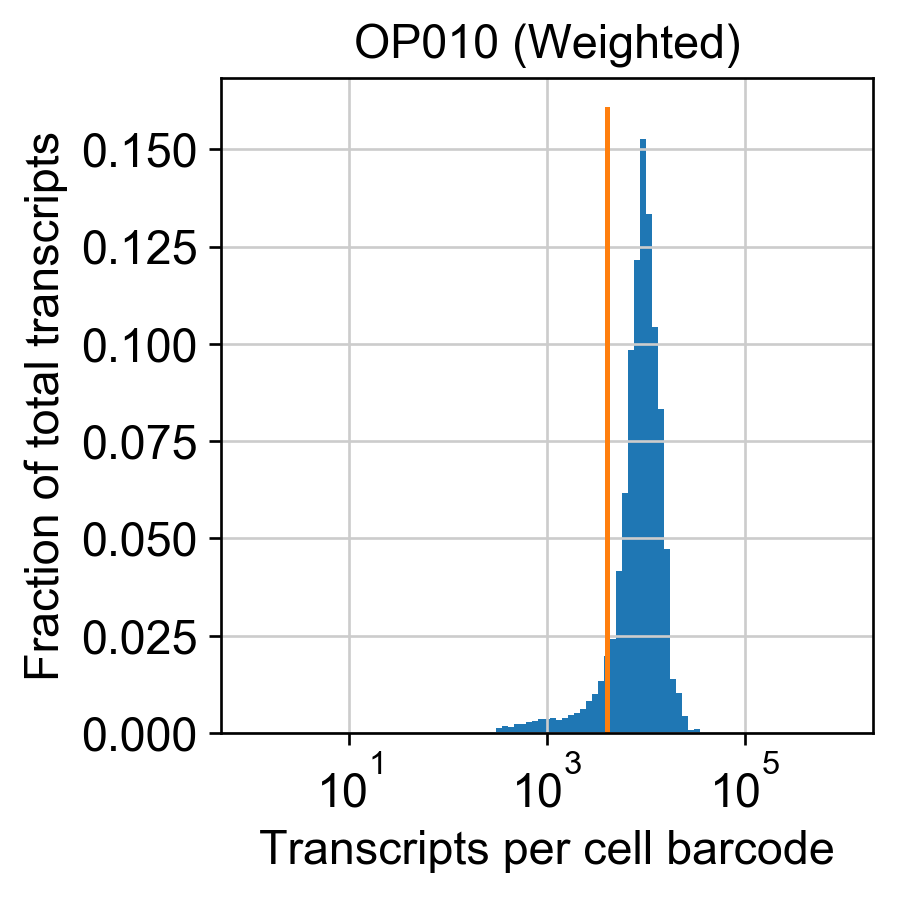

Filtering barcodes for OP010  ( 3433 / 5763 )
filtered out 2330 cells that have less than 4000 counts


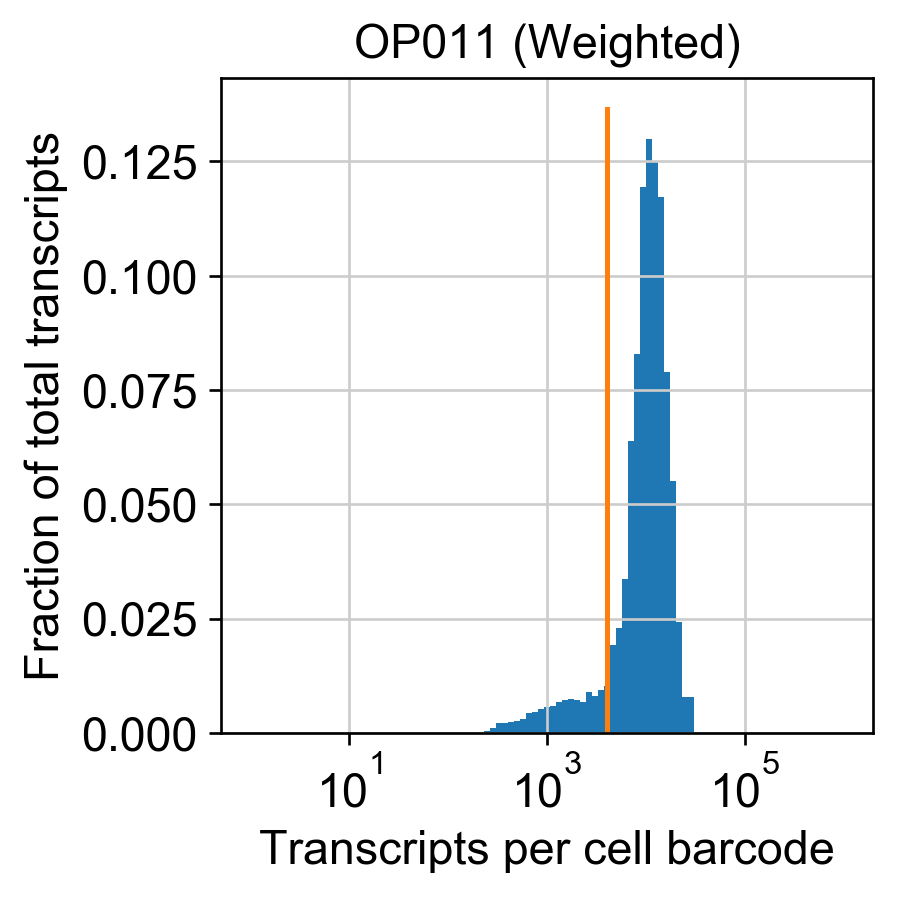

Filtering barcodes for OP011  ( 2213 / 4652 )
filtered out 2439 cells that have less than 4000 counts

 AnnData object with n_obs × n_vars = 5646 × 40523 
    obs: 'batch', 'cell_names', 'library_id', 'n_counts', 'unique_cell_id'


In [3]:
# load libraries
#input_path = '/Users/dan/Dropbox (HMS)/Data/inDrops/OP_Oscillations/' # full path to all inDrops datasets
input_path = '../_rawData/' # full path to all inDrops datasets
libnames_mmE95 = ['OP010','OP011']
mmE95 = dew.load_inDrops_V3(libnames_mmE95, input_path)

# set barcode abundance threshold
mmE95['OP010']['adata'].uns['counts_thresh'] = 4000
mmE95['OP011']['adata'].uns['counts_thresh'] = 4000

# perform filtering
for s in libnames_mmE95:
    dew.filter_abundant_barcodes(mmE95[s]['adata']) # filter and save histogram plots to file
    
# merge all libraries    
mmE95 = mmE95['OP010']['adata'].concatenate(mmE95['OP011']['adata'])
print('\n',mmE95)

### Save AnnData DataSet to File

In [4]:
mmE95.obs.to_csv('Diaz2019_mmE95_obs.csv')
mmE95.write('Diaz2019_mmE95.h5ad')

... storing 'cell_names' as categorical
... storing 'library_id' as categorical


### Identify Putative Cell Doublets using 'Scrublet' (Wolock 2018)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 15.6%
Estimated detectable doublet fraction = 82.4%
Overall doublet rate:
	Expected   = 25.0%
	Estimated  = 18.9%
Elapsed time: 14.4 seconds
Doublet-like Cells = 878


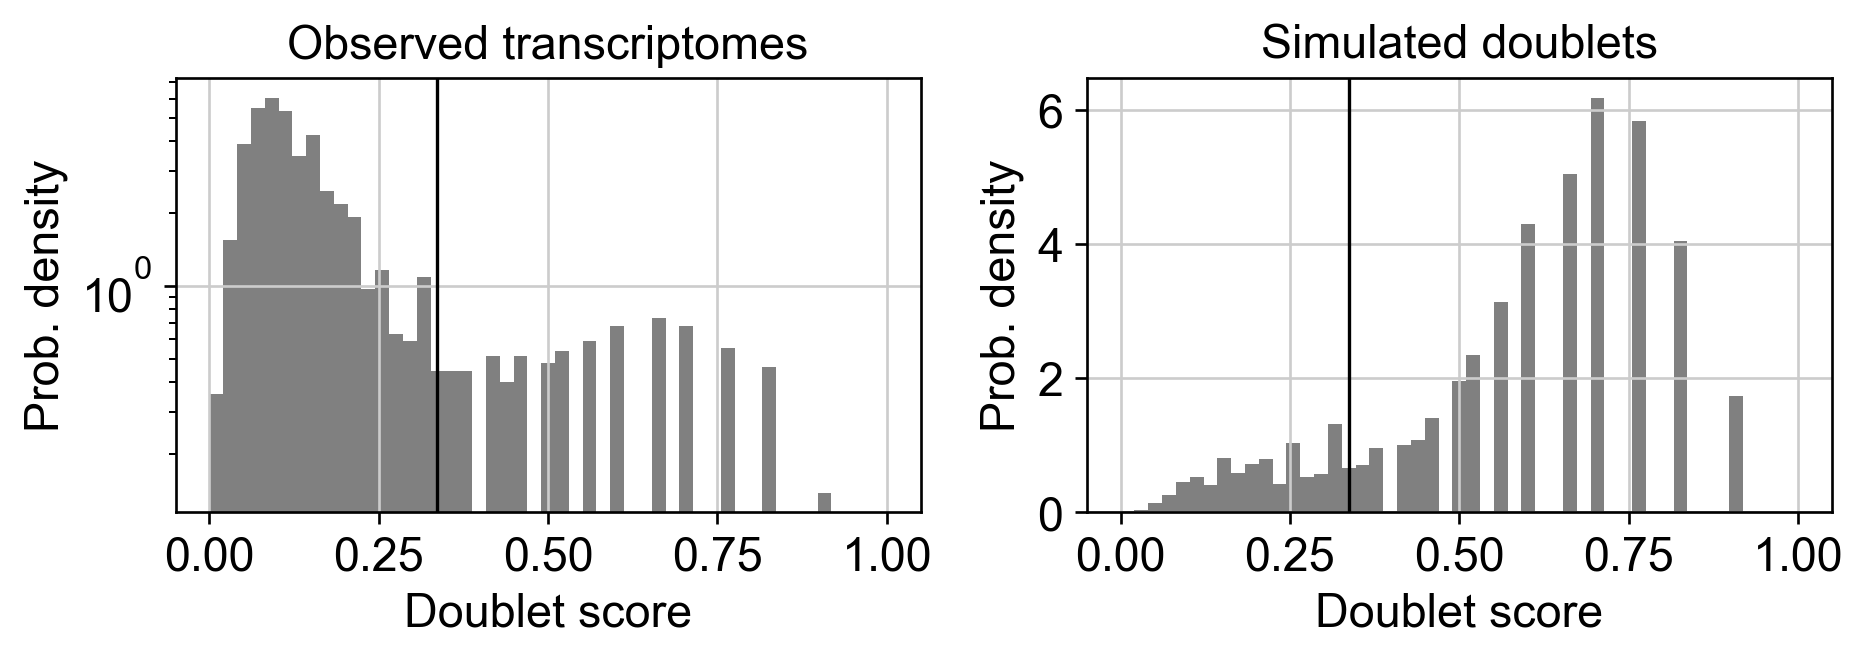

In [5]:
# Identify and plot putative doublet cells
np.random.seed(802) # set random seed for reproducibility
scrub = scr.Scrublet(mmE95.X, n_neighbors = 20, expected_doublet_rate=0.25)
mmE95.obs['doublet_scores'], mmE95.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram();
print("Doublet-like Cells = {:d}" .format(sum(mmE95.obs['predicted_doublets'])))

Detected doublet rate = 22.7%
Estimated detectable doublet fraction = 89.4%
Overall doublet rate:
	Expected   = 25.0%
	Estimated  = 25.3%
Doublet-like Cells = 1279


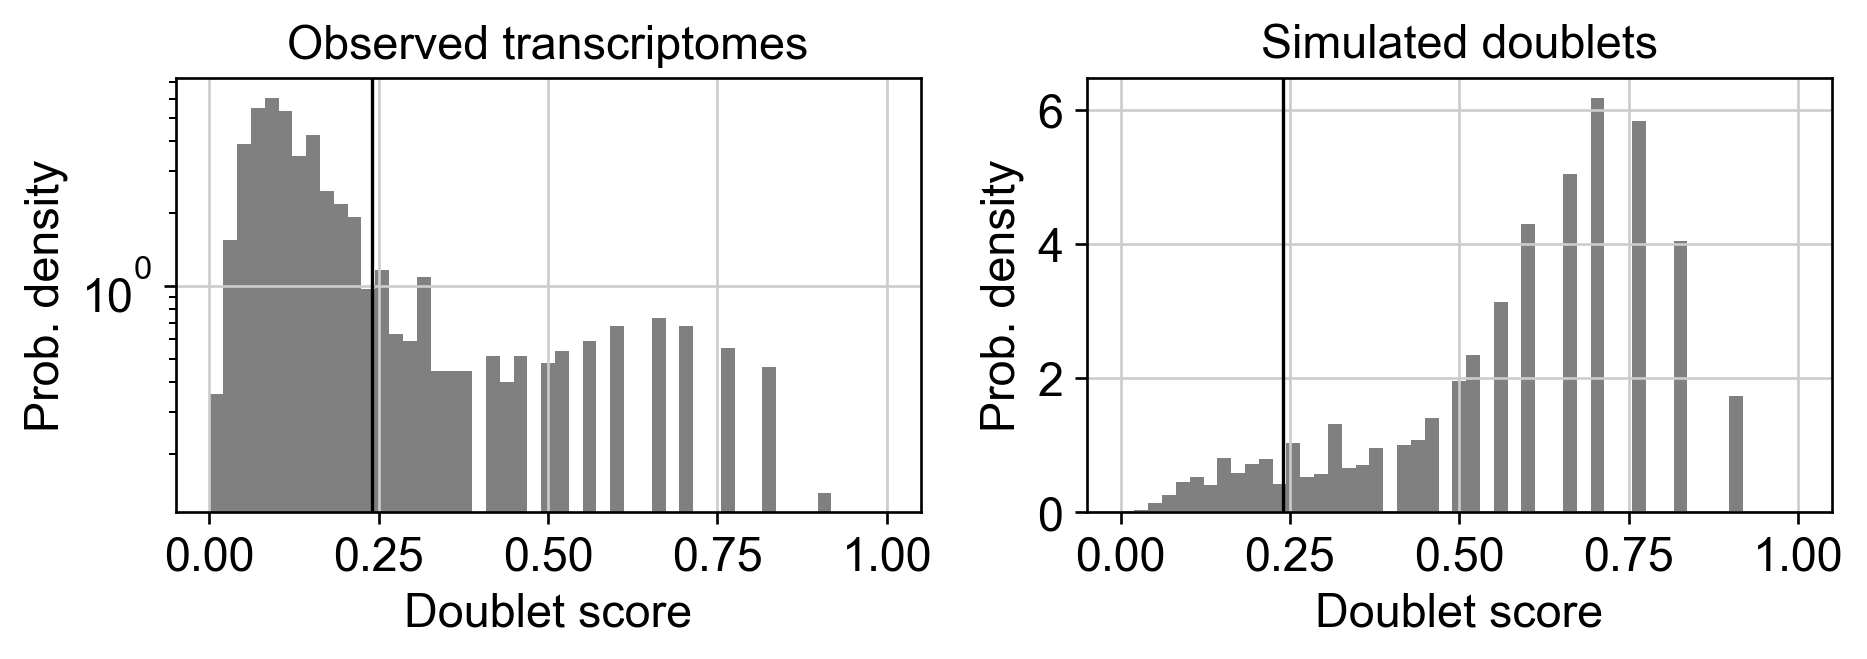

In [6]:
# Adjust doublet score threshold 
mmE95.obs['predicted_doublets'] = scrub.call_doublets(threshold=0.24)
fg,ax = scrub.plot_histogram();
print("Doublet-like Cells = {:d}" .format(sum(mmE95.obs['predicted_doublets'])))
fg.savefig('./figures/scrublet_mmE95_hist.png', bbox_inches='tight')

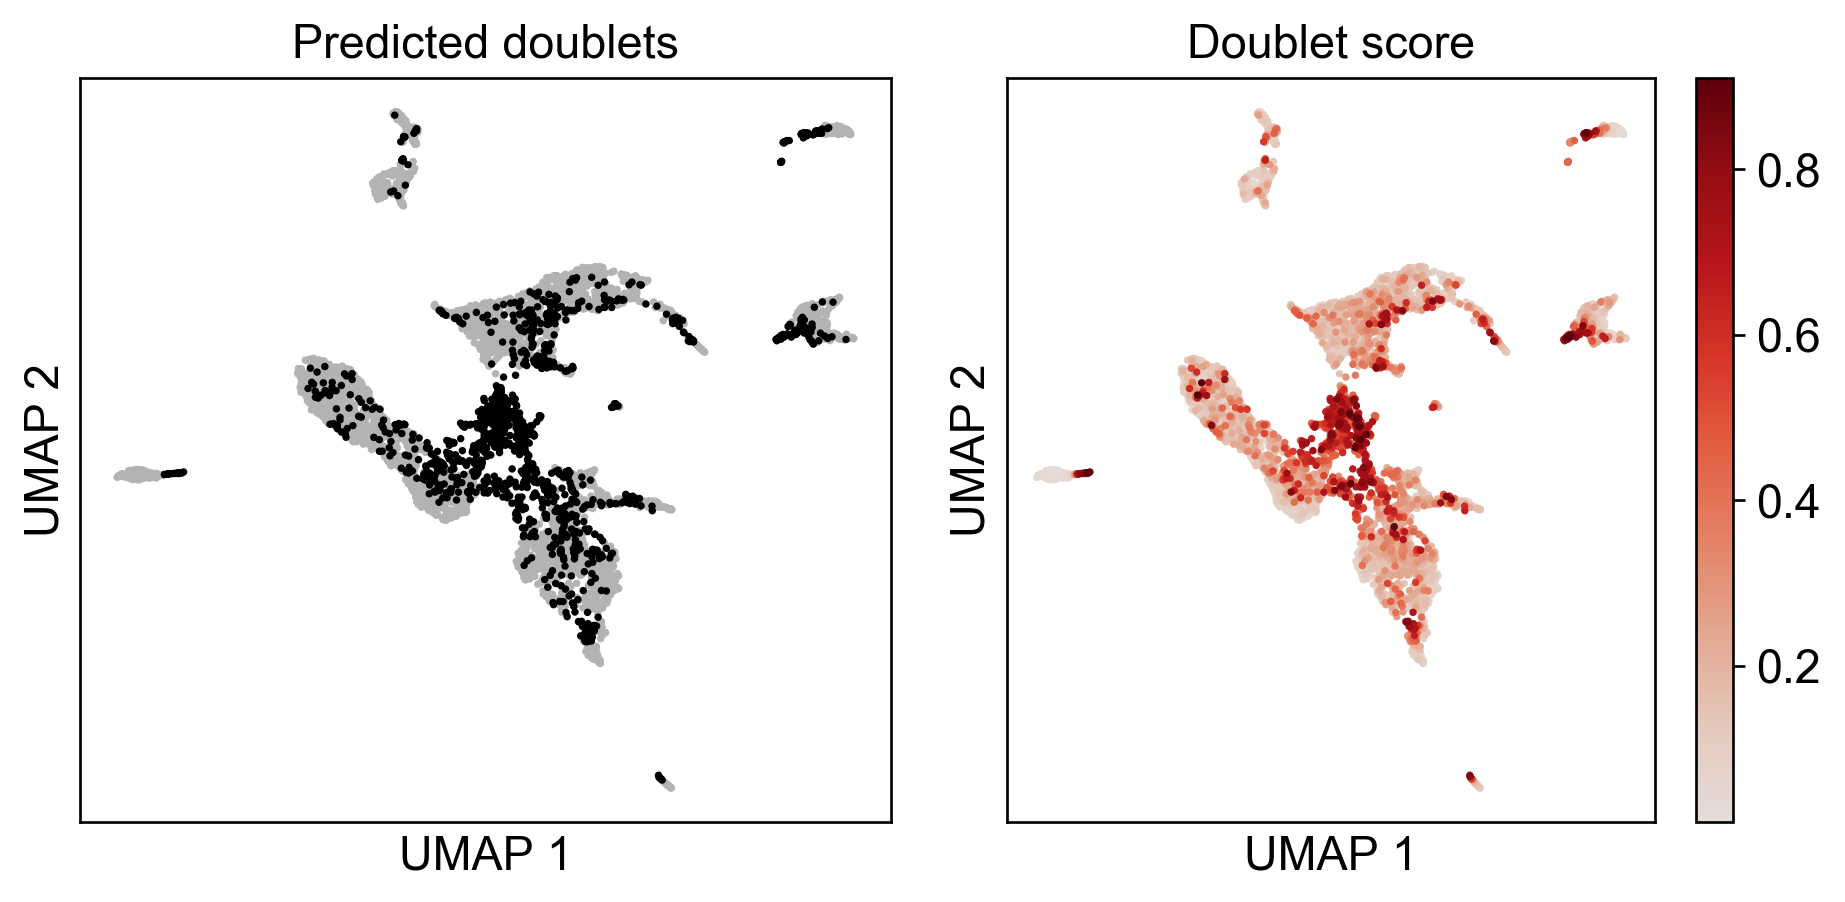

In [7]:
# Overlay doublet scores on a quick UMAP embedding 
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, n_neighbors=10, min_dist=0.2))
fg,ax = scrub.plot_embedding('UMAP', order_points=True);
fg.savefig('./figures/scrublet_mmE95_umap.png', bbox_inches='tight')

In [8]:
# Generate a new doublet-filtered ('df') AnnData object 
print("Total Cells = {:d}" .format(len(mmE95)))
print("Doublet-like Cells = {:d}" .format(sum(mmE95.obs['predicted_doublets'])))
print("Non-Doublet Cells = {:d}" .format(len(mmE95) - sum(mmE95.obs['predicted_doublets'])))
mmE95_df = mmE95[~mmE95.obs['predicted_doublets'],:]
mmE95_df

Total Cells = 5646
Doublet-like Cells = 1279
Non-Doublet Cells = 4367


View of AnnData object with n_obs × n_vars = 4367 × 40523 
    obs: 'batch', 'cell_names', 'library_id', 'n_counts', 'unique_cell_id', 'doublet_scores', 'predicted_doublets'

### Process & Normalize

In [9]:
# Perform basic filtering
sc.pp.filter_cells(mmE95_df, min_genes=250)

# Before doing any further processing, store a raw version of the data
mmE95_df.raw = sc.pp.log1p(mmE95_df, copy=True)
mmE95_df.raw = mmE95_df

# First, save current n_counts as n_counts_pre_norm (n_counts will be replaced)
mmE95_df.obs['n_counts_pre_norm'] = mmE95_df.obs['n_counts']

# Perform total counts normalization
sc.pp.normalize_total(mmE95_df)

# Logarithmize the data
sc.pp.log1p(mmE95_df)

# Identify highly variable genes
sc.pp.highly_variable_genes(mmE95_df, n_top_genes=2000)

# Scale the data
sc.pp.scale(mmE95_df)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


### Compute Embeddings

In [10]:
# Perform PCA and construct neighbor graph
sc.tl.pca(mmE95_df, n_comps=40, svd_solver='arpack')
sc.pp.neighbors(mmE95_df, n_neighbors=10, n_pcs=40, use_rep='X_pca') #neigh 20

# Compute sklearn-tSNE and UMAP embeddings
sc.tl.tsne(mmE95_df, use_fast_tsne=False, random_state=802) # set to 'None' to get a random tSNE embedding
sc.tl.umap(mmE95_df)

computing PCA with n_comps = 40
computing PCA on highly variable genes
    finished (0:00:00.45)
computing neighbors
    finished (0:00:04.81) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing tSNE
    using 'X_pca' with n_pcs = 40
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:40.09) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing UMAP


/Users/dan/miniconda2/envs/py36/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


    finished (0:00:06.68) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [11]:
# Perform clustering
sc.tl.leiden(mmE95_df, resolution=0.6)
sc.tl.louvain(mmE95_df, resolution=0.85)

running Leiden clustering
    finished (0:00:00.46) --> found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.31) --> found 21 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


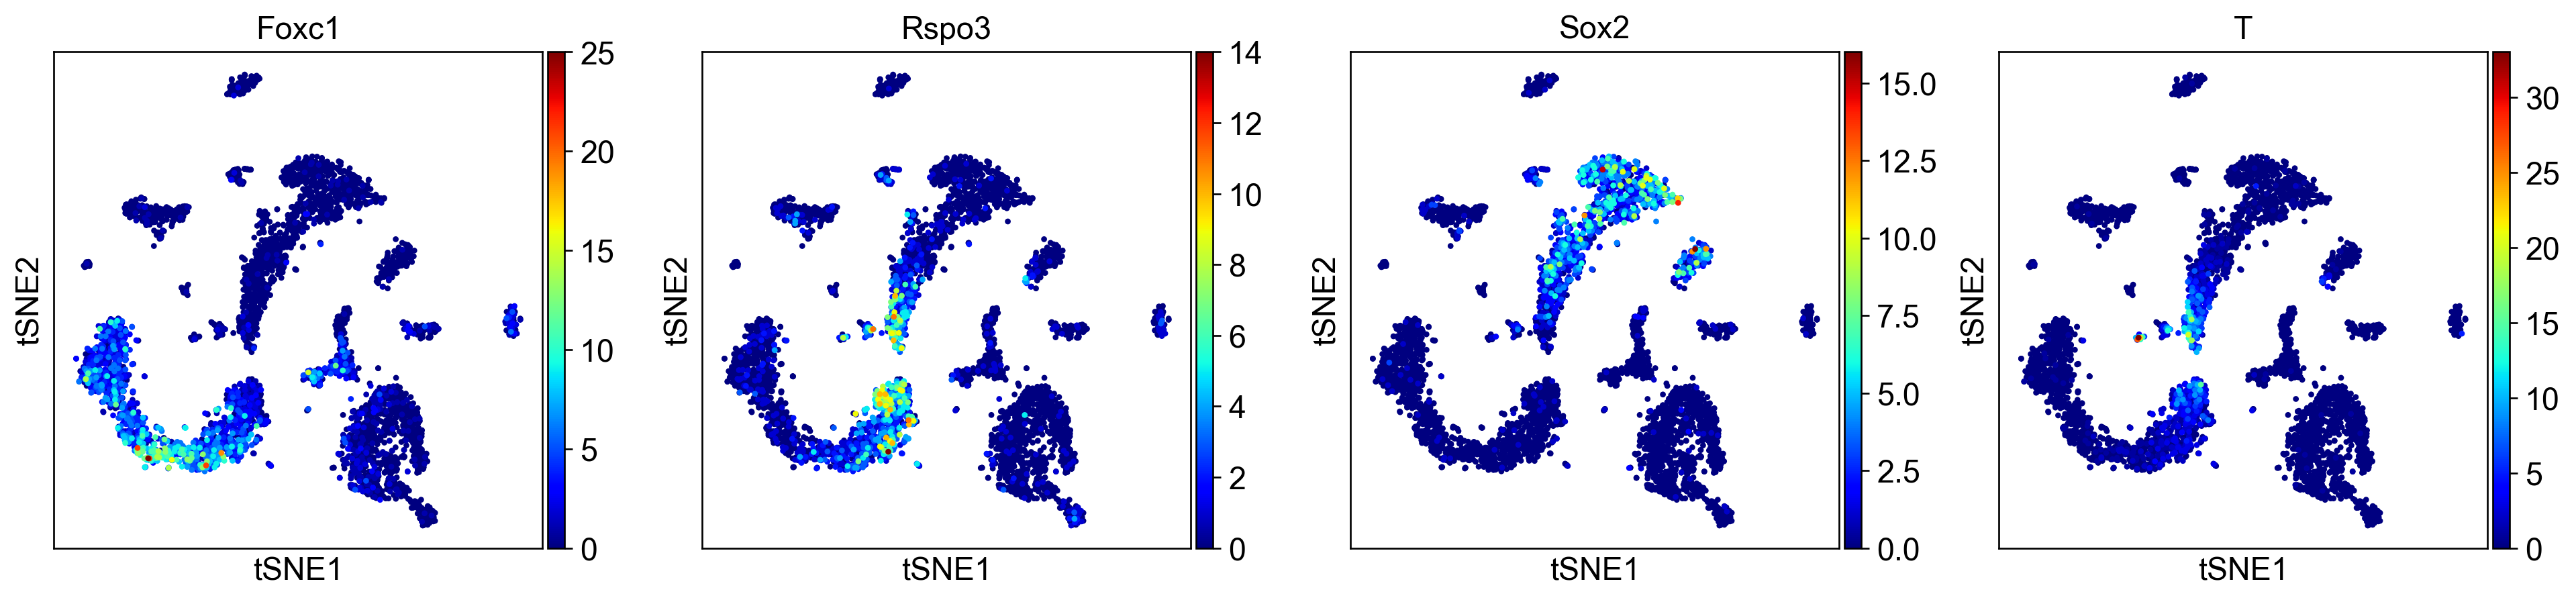

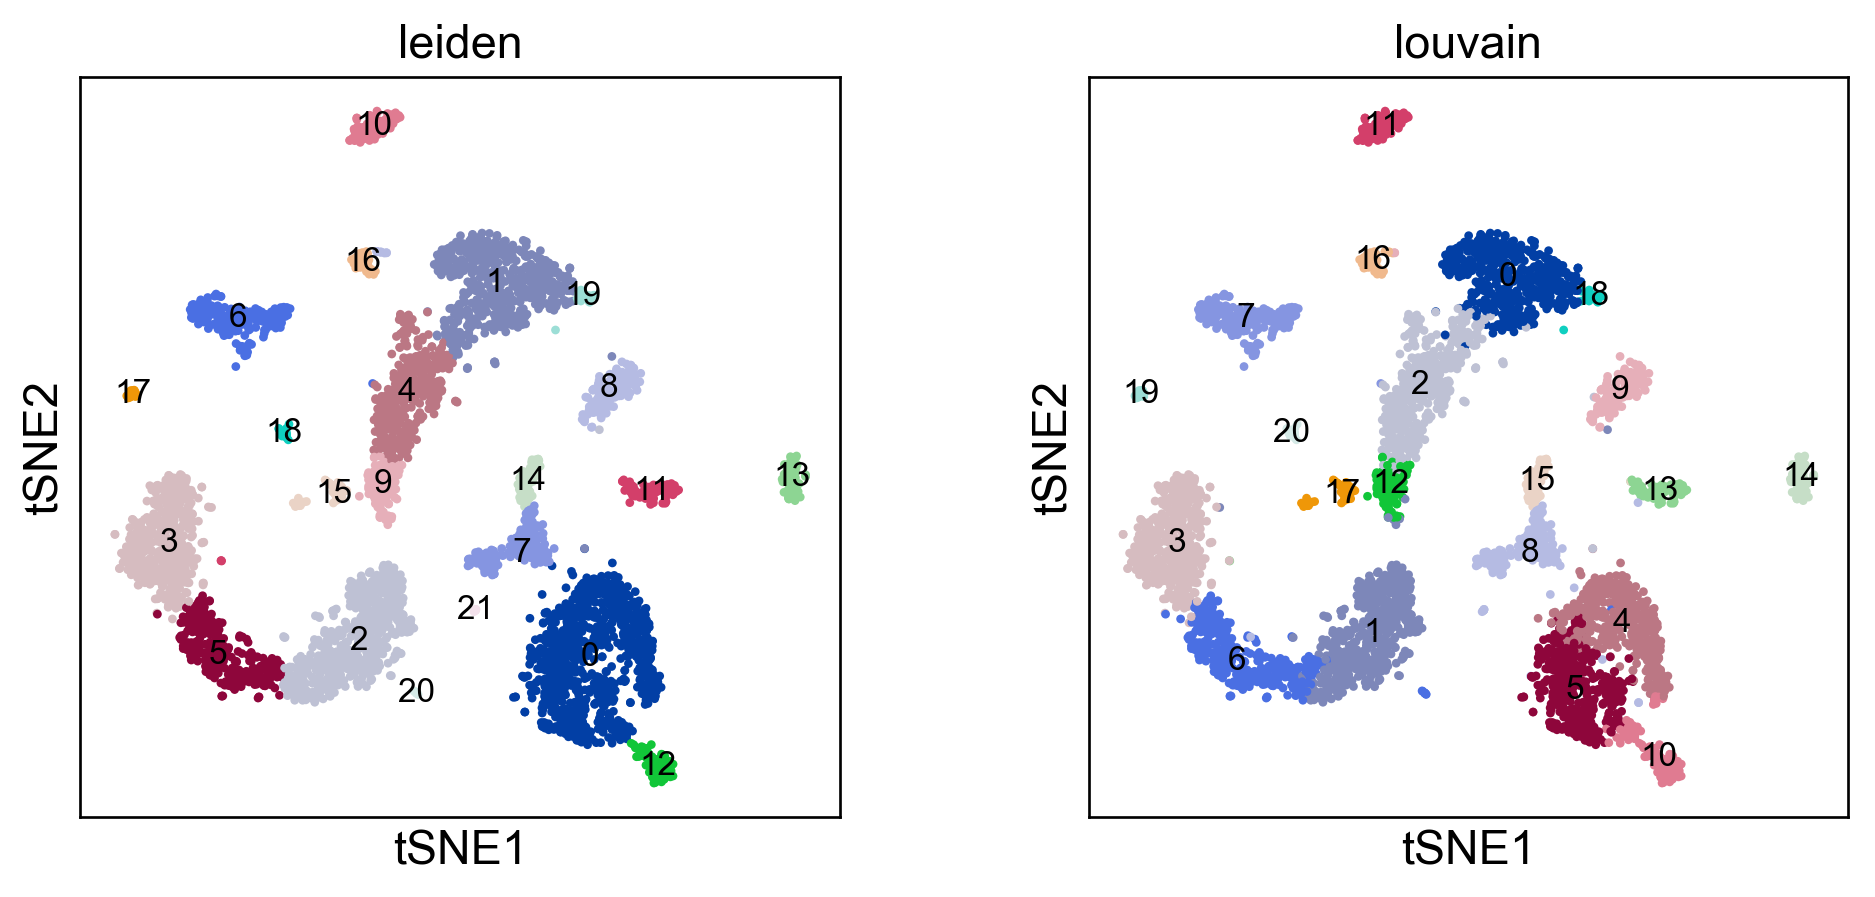

In [12]:
# Plot embeddings
# Overlay genes
sc.pl.tsne(mmE95_df, color=['Foxc1', 'Rspo3','Sox2', 'T'], cmap='jet')

# Overlay cluster assignments
sc.pl.tsne(mmE95_df, color=['leiden','louvain'], edges=False, frameon=True, legend_loc='on data', 
           legend_fontsize=10, legend_fontweight='medium')


saving figure to file ./figures/tsne_mmE95_leiden.pdf


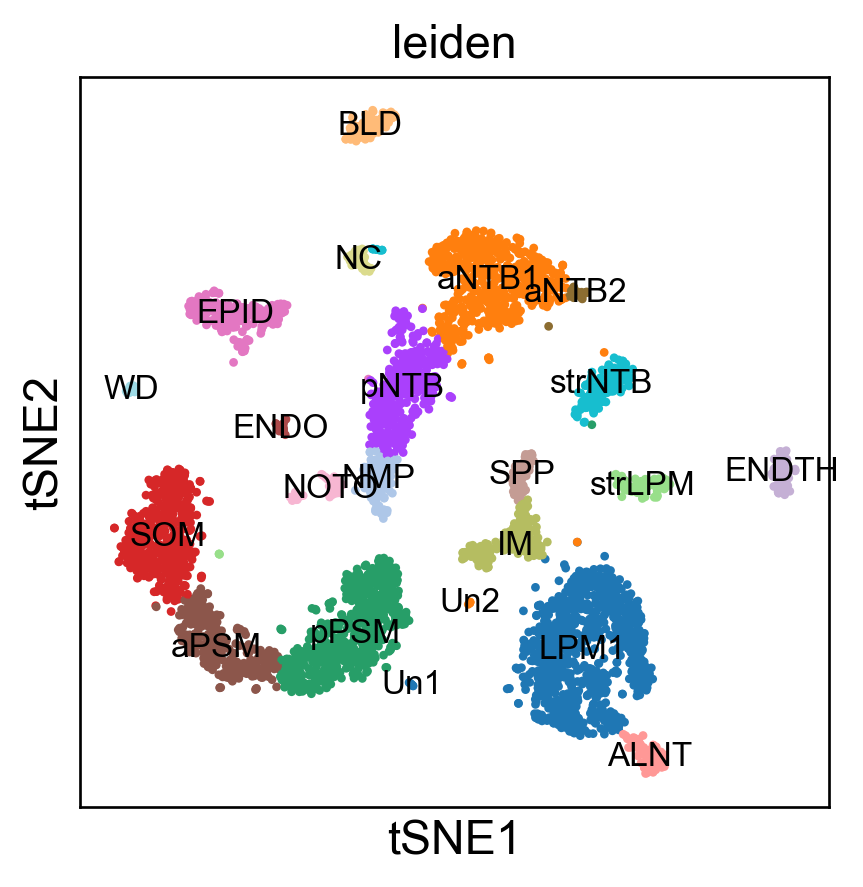

saving figure to file ./figures/tsne_mmE95_leiden_nolabel.png


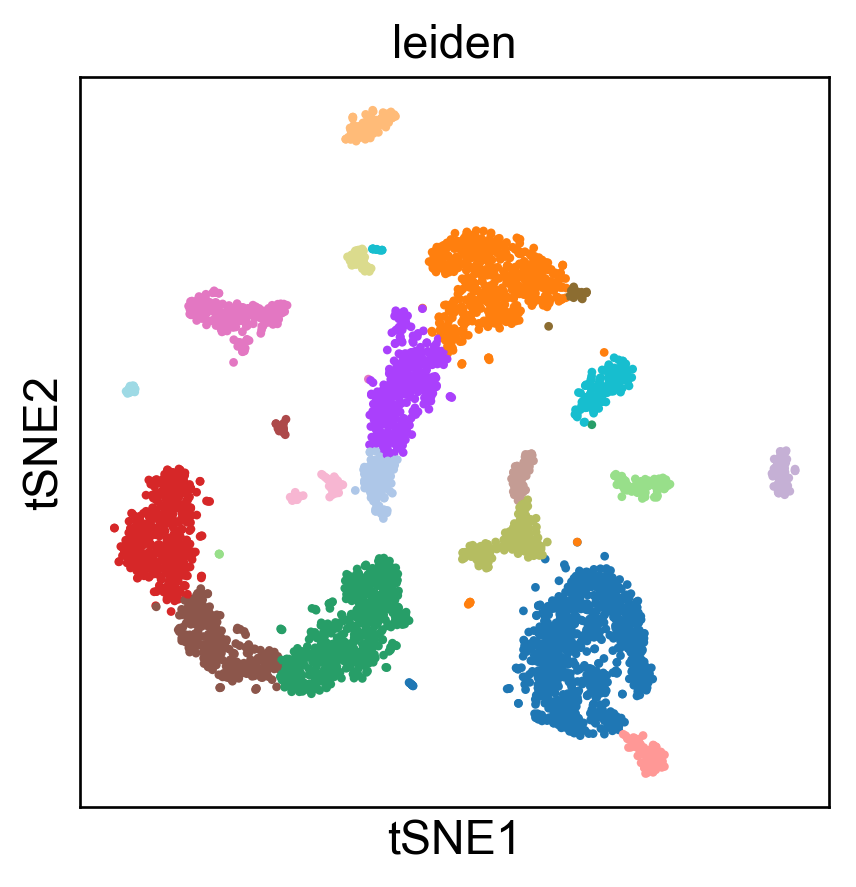

saving figure to file ./figures/tsne_mmE95_louvain.pdf


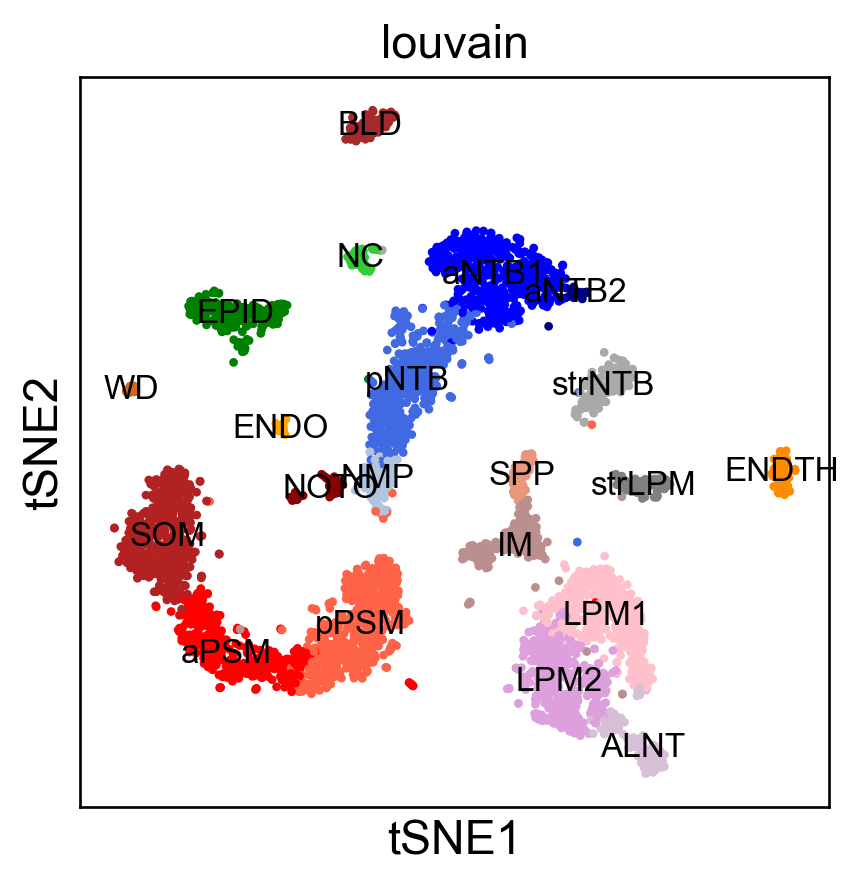

saving figure to file ./figures/tsne_mmE95_louvain.png


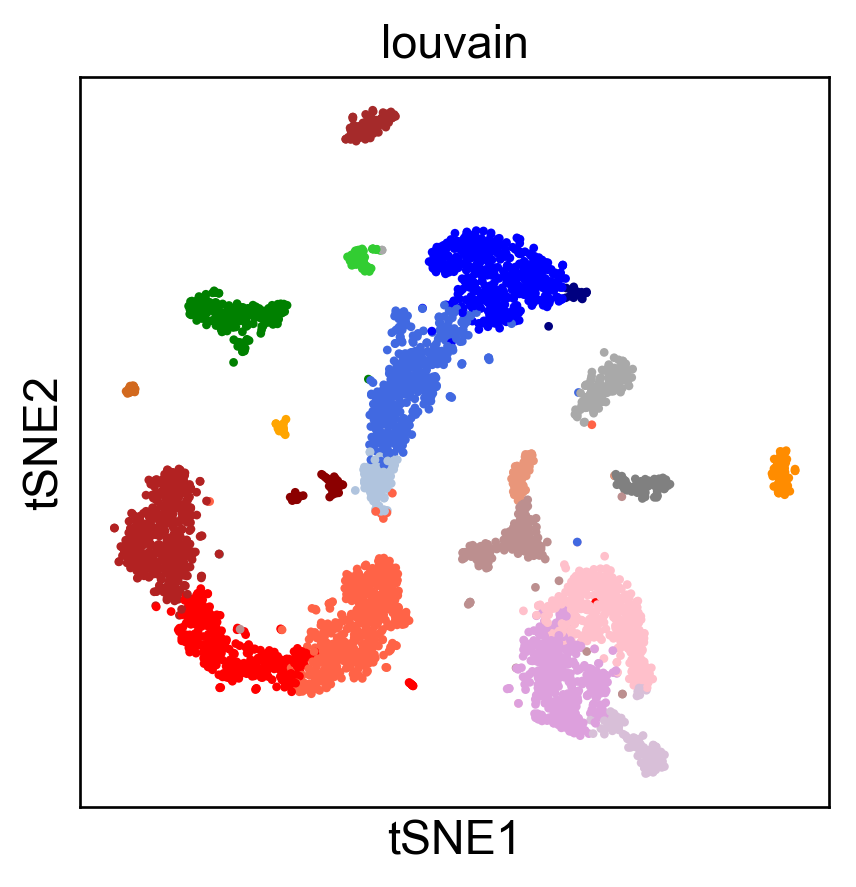

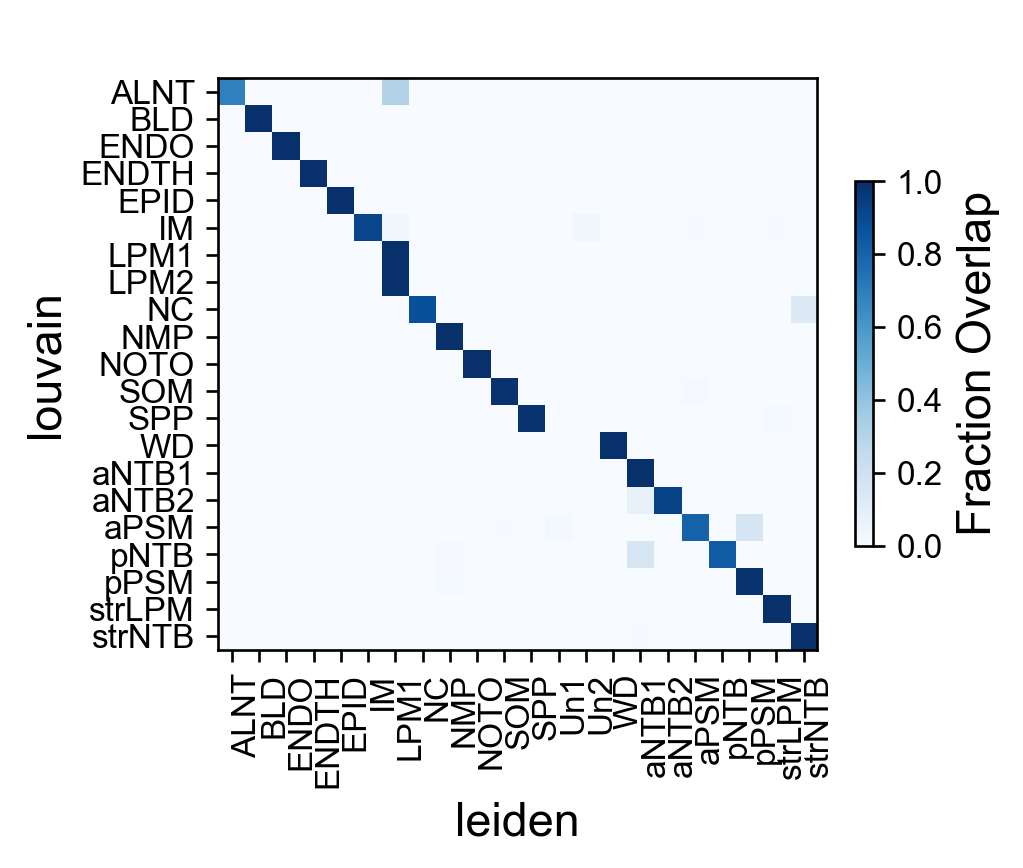

In [13]:
# Manual annotation of cluster names
new_leiden_names = ['LPM1', 'aNTB1', 'pPSM', 'SOM', 'pNTB', # 0-4
                    'aPSM', 'EPID', 'IM', 'strNTB', 'NMP', # 5-9
                    'BLD', 'strLPM', 'ALNT', 'ENDTH', 'SPP', # 10-14
                    'NOTO', 'NC', 'WD', 'ENDO', 'aNTB2', # 15-19
                    'Un1', 'Un2'] # 20-21

new_louvain_names = ['aNTB1', 'pPSM', 'pNTB', 'SOM', 'LPM1', # 0-4
                     'LPM2', 'aPSM', 'EPID', 'IM', 'strNTB', # 5-9
                     'ALNT', 'BLD', 'NMP', 'strLPM', 'ENDTH', # 10-14
                     'SPP', 'NC', 'NOTO', 'aNTB2', 'WD', 'ENDO'] # 15-20

mmE95_df.rename_categories('leiden', new_leiden_names)
mmE95_df.rename_categories('louvain', new_louvain_names)

# Overlay new cluster assignments
sc.pl.tsne(mmE95_df, color=['leiden'], edges=False, frameon=True,
           legend_loc='on data', legend_fontsize=10, legend_fontweight='medium', palette=plt.rcParams['axes.prop_cycle'],
           save='_mmE95_leiden.pdf')
sc.pl.tsne(mmE95_df, color=['leiden'], edges=False, frameon=True,
           legend_loc='none', legend_fontsize=10, legend_fontweight='medium',
           save='_mmE95_leiden_nolabel.png')

sc.pl.tsne(mmE95_df, color=['louvain'], palette=['blue', 'tomato', 'royalblue', 'firebrick', 'pink', 'plum', 
           'red', 'green', 'rosybrown', 'darkgrey', 'thistle', 'brown', 'lightsteelblue', 'grey', 'darkorange', 
           'darksalmon', 'limegreen', 'darkred','navy', 'chocolate', 'orange'],
           edges=False, frameon=True,legend_loc='on data', legend_fontsize=10, legend_fontweight='medium', save='_mmE95_louvain.pdf')
sc.pl.tsne(mmE95_df, color=['louvain'], edges=False, frameon=True, legend_loc='none', legend_fontsize=10, legend_fontweight='medium',save='_mmE95_louvain.png')

# Plot a confusion matrix to compare clustering assignments
fg,ax = dew.plot_confusion_matrix(mmE95_df.obs['leiden'], mmE95_df.obs['louvain'], title=' ', normalize=True)
fg.savefig('./figures/confmat_mmE95_leidenlouvain.png', bbox_inches='tight')

### Get Marker Genes

In [14]:
# Subset only the 'non-stressed' cells
mmE95_df_nostr = mmE95_df[~mmE95_df.obs['louvain'].isin(['strLPM','strNTB']),:]

sc.tl.rank_genes_groups(mmE95_df_nostr, 'louvain', use_raw=True, reference='rest', n_genes=100, 
                        method='wilcoxon', corr_method='benjamini-hochberg', log_transformed=True)

ranking genes


/Users/dan/Dropbox (HMS)/Code/Git/scanpy/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's
/Users/dan/Dropbox (HMS)/Code/Git/scanpy/scanpy/tools/_rank_genes_groups.py:387: RuntimeWarning: divide by zero encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished (0:00:24.18) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


    using 'X_pca' with n_pcs = 40
Storing dendrogram info using `.uns['dendrogram_louvain']`


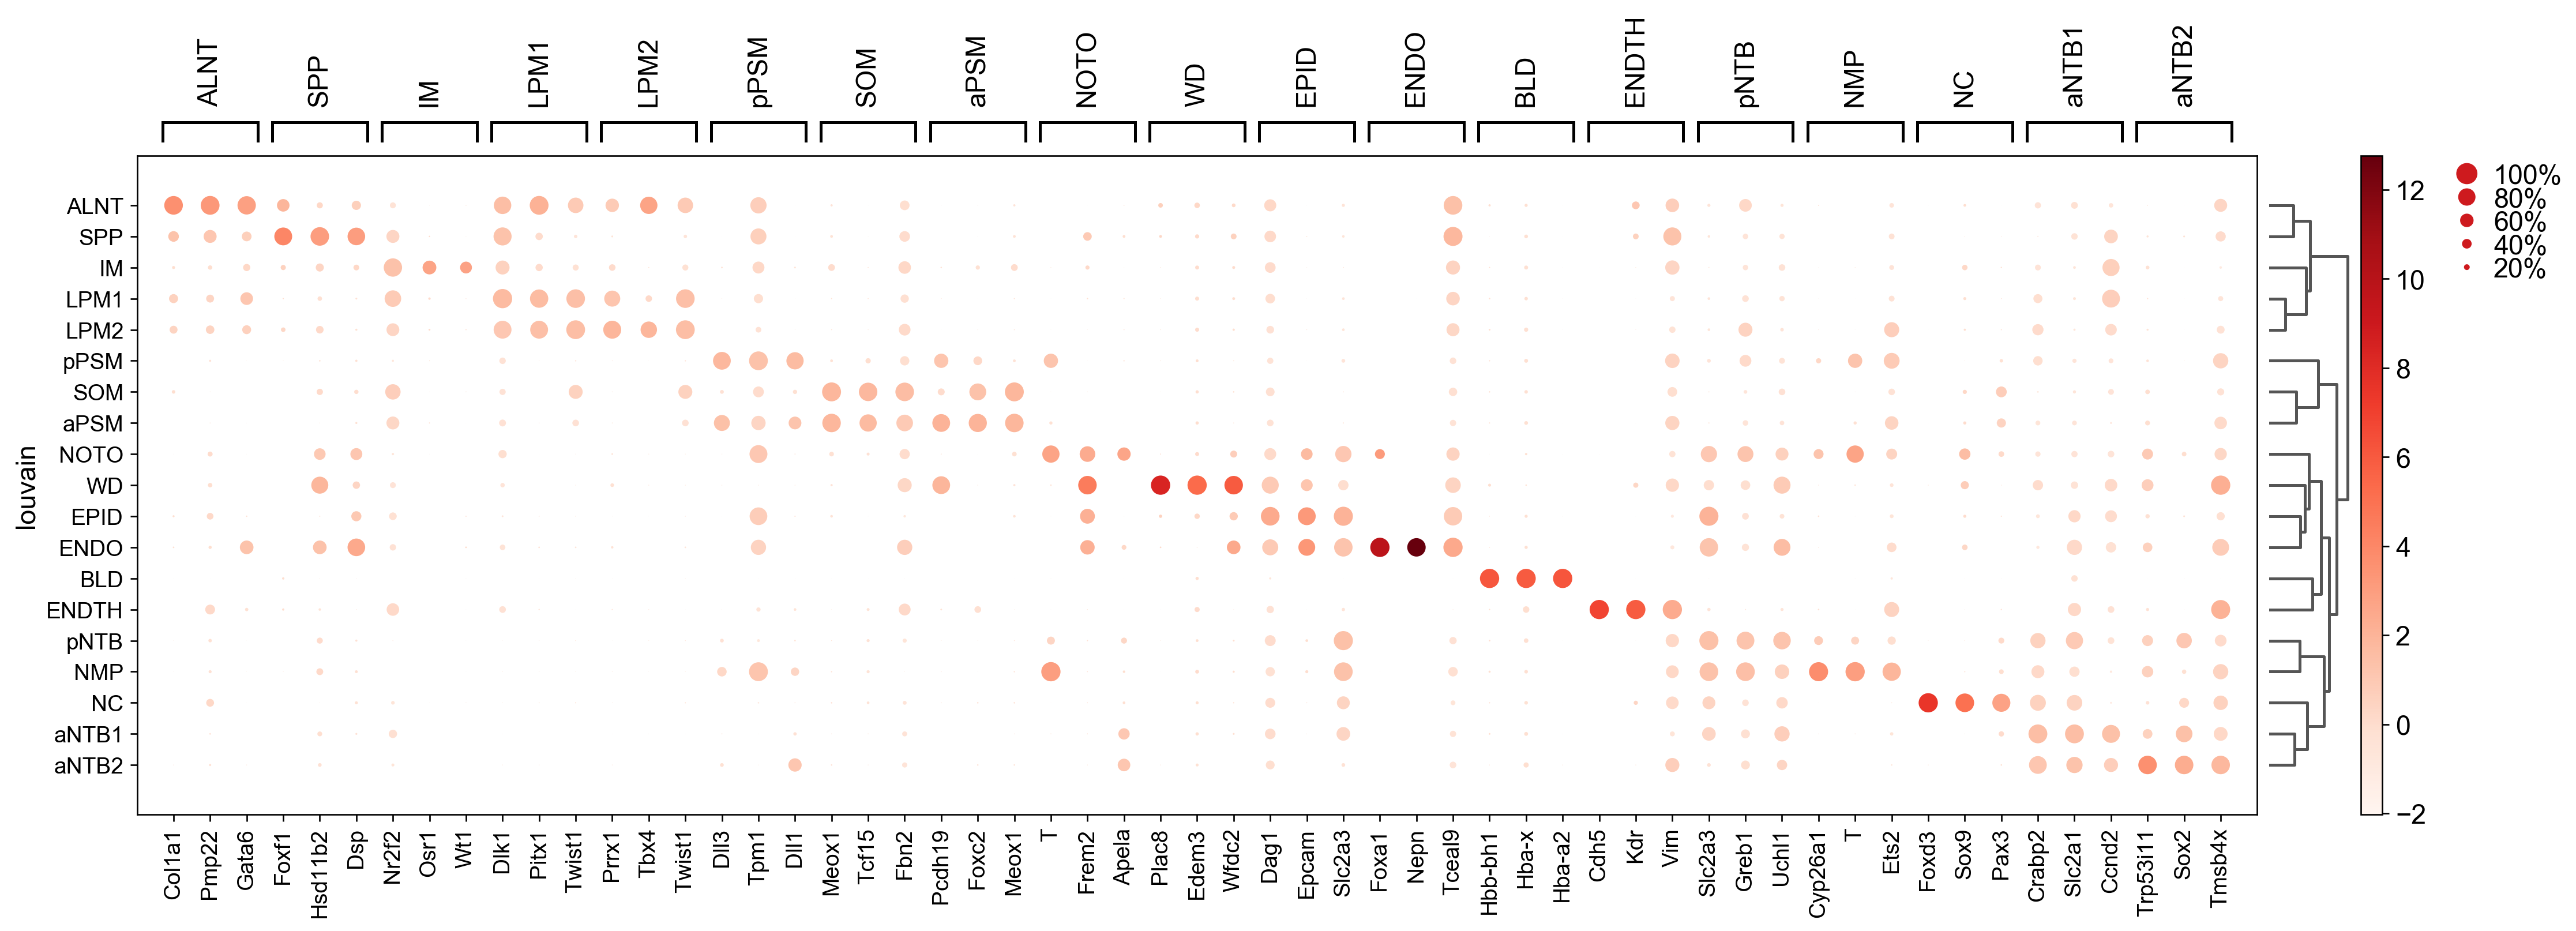

In [15]:
sc.tl.dendrogram(mmE95_df_nostr, groupby='louvain')
sc.pl.rank_genes_groups_dotplot(mmE95_df_nostr, n_genes=3, groupby='louvain', log=False, use_raw=False); 

In [16]:
# Generate a tables of differentially expressed genes for each group
deg = mmE95_df_nostr.uns['rank_genes_groups']
groups = deg['names'].dtype.names

# Format a table with top 100 gene names and corrected p-values, export to excel
df_names_pvals = pd.DataFrame({groups+'_'+key: deg[key][groups] for groups in groups for key in ['names','logfoldchanges','pvals']}).head(100)
df_names_pvals.to_excel('tables/mmE95_DEGTable.xlsx')

In [17]:
# Print top 20 gene names to screen~
pd.DataFrame({groups : deg[key][groups] for groups in groups for key in ['names']}).head(20)

aNTB1     pPSM    pNTB      SOM    LPM1    LPM2     aPSM     EPID  \
0    Crabp2     Dll3  Slc2a3    Meox1    Dlk1   Prrx1   Pcdh19     Dag1   
1    Slc2a1     Tpm1   Greb1    Tcf15   Pitx1    Tbx4    Foxc2    Epcam   
2     Ccnd2     Dll1   Uchl1     Fbn2  Twist1  Twist1    Meox1   Slc2a3   
3       Ptn   Cited1    Sox3     Arg1    Gas1  Hoxd13    Foxc1    Pdgfa   
4      Sox3     Nkd2  Hoxc10    Foxc2    Mest   Pitx1    Tcf15   Hapln1   
5   Fam181b    Rspo3   Mkrn1     Ntn1  Col3a1   Capn6     Ntn1     Bcam   
6      Sox2     Smc6  Pmaip1    Foxd1   Prrx1    Tril  Epb41l3   Igfbp5   
7      Pax6     Btg2   Sall4    Cadm1    Rian   Hand2     Dll3    Trp63   
8     Sfrp2    Nrarp    Sox2    Foxc1   Hand2    Dlk1     Add3     Perp   
9     Map1b   Ifitm1  Slc2a1   Phlda1    Meg3   Igf2r    Pcdh8     Wnt6   
10   Tubb2b     Eogt    Chd3  Selenop    Peg3   Peg10   Notch1   Pdlim1   
11     Sox1     Lef1    Cdx2      Fst   Nr2f2    Dok4     Lef1    Ahnak   
12     Prtg  Hoxaas3  Kcnab3  Col26a1   Ccnd2   Dusp9   Cited2    Itga3   
13     Utrn      Fn1  Arid3b  Aldh1a2  Crabp1    Isl1    Foxp1    Cldn6   
14     Bex4    Arl4d   Syt11  Epb41l3   Gata6    Igf2    Cadm1    Ptprf   
15    Pcsk9     Hes7     Oat    Fxyd6    Irx5     H19     Arg1     Cdh3   
16    Fabp5    Sept8  Plagl1    Fstl1  Igfbp4    Bmp4    Nrarp  Col18a1   
17   Fgfbp3     Lmo2  Hoxd11   Cxcl12   Peg10    Peg3  Laptm4b    Frem2   
18    Apela   Hoxd11  Lin28a    Ncam1    Odc1   Prrx2     Lmo4     Igf2   
19     Mycl     Tbx6    Zic5   Marcks    Bmp4   Unc5c     Nrep   Spint2   

         IM    ALNT       BLD      NMP   ENDTH      SPP        NC    NOTO  \
0     Nr2f2  Col1a1   Hbb-bh1  Cyp26a1    Cdh5    Foxf1     Foxd3       T   
1      Osr1   Pmp22     Hba-x        T     Kdr  Hsd11b2      Sox9   Frem2   
2       Wt1   Gata6    Hba-a2     Ets2     Vim      Dsp      Pax3   Apela   
3      Arg1  Phlda2    Hba-a1     Fgf8    Emcn   Tceal9   Gadd45a  Spint2   
4      Igf2    Krt8      Car2    Rspo3    Cd34   Col3a1   Aldh1a2  Pla2g7   
5      Mest  Col1a2     Hbb-y     Cdx2   Gng11     Krt8   Gm12688   Slit2   
6     Nr2f1   Peg10  Slc25a37    Fgf17  Rasip1    Krt18      Wnt1  Cdkn1a   
7       H19    Tbx4    Cited4    Greb1   Plvap    Foxf2       Id3    Tpm1   
8   B4galt6   Pitx1      Gpx1   Hoxd11  Igfbp4    Podxl    Tubb2b     Ezr   
9      Fzd2    Peg3      Fth1   Slc2a3    Esam     Bex3      Mest   Epcam   
10     Peg3    Myrf   Tmem14c     Npm3   Egfl7     Myrf      Msx1     Fn1   
11  Gm14226    Igf2      Cpox    Ccnjl  Hapln1    Ptch1      Ets1   Cldn6   
12     Pbx1     H19      Hmbs     Ptk7   Sparc     Peg3    Tfap2b   Greb1   
13   Cdkn1c   Capn6      Gypa   Arid3b   Crip2      Vim  Arhgef26   Foxa1   
14    Ccnd2  Col3a1    Slc4a1     Tpm1    Mest      Hlx      Pak3   Rspo3   
15     Bmp4    Sgce      Fech     Hes7  Tmsb4x   Nkx2-3      Enc1  Slc2a3   
16     Eya1  Igfbp5   Slc39a8   Sema6a  Col4a2    Acta2     Hoxc9   Sall3   
17    Foxc1   Hand2      Gmpr     Evx1   Gap43     Dlk1     Map1b    Mnx1   
18    Rbms1    Asb4     Hebp1  Hoxaas3  Pecam1    Sparc    Pknox2    Cdx2   
19   Cldn11    Rian      Sptb    Wnt5a  Plxnd1  B4galt6     Sox10   Foxa2   

       aNTB2       WD    ENDO  
0   Trp53i11    Plac8   Foxa1  
1       Sox2    Edem3    Nepn  
2     Tmsb4x    Wfdc2  Tceal9  
3       Hes6    Gata3    Bex1  
4     Btbd17      Ret   Cldn6  
5        Nin    Gap43  Rnase4  
6    Igfbpl1     Npnt    Peg3  
7     Rnf165   Tmsb4x    Cdh1  
8     Elavl4    Frem2    Bex4  
9       Utrn   Sema6a    Krt8  
10     Mkrn1     Lhx1    Gpc3  
11   Neurog2    Fstl1   Krt18  
12      Miat     Asb4  Igfbp5  
13     Olig2     Emx2   Pcbd1  
14   Prkar2a    Capn6   Glud1  
15    Cdkn1c   Hapln1   Epcam  
16     Spsb4     Fzd4     Dsp  
17    Pou3f2    Socs2  Spint2  
18    Nkx6-1  Aldh1a3     Emb  
19    Sox2ot  Tsc22d1     Afp

In [39]:
# Print number of cells in each cluster
nTotalCells = len(mmE95_df.obs)
for name in np.unique(mmE95_df.obs['louvain']):
    nCells = sum(mmE95_df.obs['louvain'].isin([name]))
    fCells = nCells / nTotalCells * 100            
    print(name + ': ' + str(nCells))
print('Total nCells: ' + str(nTotalCells))

ALNT: 129
BLD: 107
ENDO: 24
ENDTH: 86
EPID: 236
IM: 190
LPM1: 389
LPM2: 377
NC: 64
NMP: 101
NOTO: 58
SOM: 437
SPP: 83
WD: 26
aNTB1: 496
aNTB2: 26
aPSM: 356
pNTB: 442
pPSM: 491
strLPM: 96
strNTB: 153
Total nCells: 4367


### Train scikit-learn Classifiers

In [18]:
# Build classifiers in PCA space
E95Classifier = dew.train_classifiers(X = mmE95_df.X, labels = mmE95_df.obs['louvain'], PCs = mmE95_df.varm['PCs'], 
                                      gene_ind = mmE95_df.var['highly_variable'])

# Save E95Classifier as lightweight pickle file
pickle.dump(E95Classifier, open('E95Classifier.pickle', 'wb'))

NearestNeighbors 0.968
RandomForest 0.963
NeuralNet 0.962
LDA 0.952


### Subset Neural and PSM cells

saving figure to file ./figures/tsne_mmE95_pm_subset.png


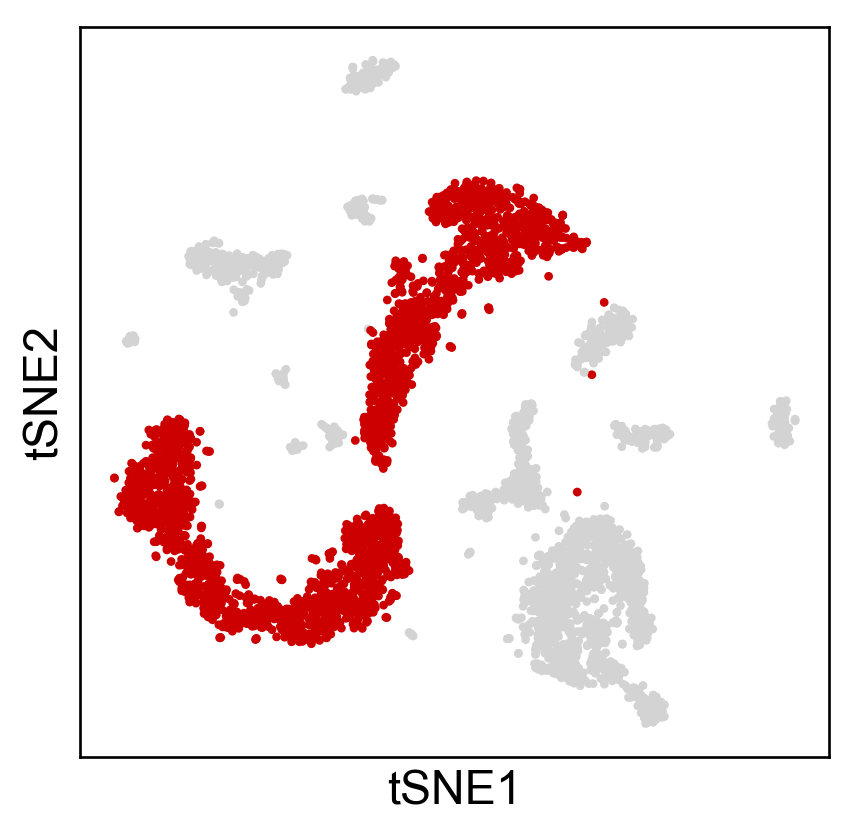

In [19]:
# Show the clusters that will be subsetted
sc.pl.tsne(mmE95_df, color='leiden', edges=False, frameon=True, title='', legend_loc=None,
           groups=['aNTB1','aNTB2','pNTB','NMP','pPSM','aPSM','SOM'] , palette=[(0.8,0,0)],
           save='_mmE95_pm_subset.png')        

In [20]:
# Reconstruct the original unprocessed data for the subsetted cells
mmE95_df_sub = mmE95[~mmE95.obs['predicted_doublets'],:]

# Subset neural and PSM cells
mmE95_df_sub = mmE95_df_sub[mmE95_df.obs['leiden'].isin(['aNTB1','aNTB2','pNTB','NMP','pPSM','aPSM','SOM'])]
mmE95_df_sub

View of AnnData object with n_obs × n_vars = 2340 × 40523 
    obs: 'batch', 'cell_names', 'library_id', 'n_counts', 'unique_cell_id', 'doublet_scores', 'predicted_doublets'

### Process and Normalize the Neural+PSM Subset

In [21]:
# Perform basic filtering
sc.pp.filter_cells(mmE95_df_sub, min_genes=250)

# Before doing any further processing, store a raw version of the data
#mmE95_df_sub.raw = sc.pp.log1p(mmE95_df_sub, copy=True)
mmE95_df_sub.raw = mmE95_df_sub

# First, save current n_counts as n_counts_pre_norm (n_counts will be replaced)
mmE95_df_sub.obs['n_counts_pre_norm'] = mmE95_df_sub.obs['n_counts']

# Perform total counts normalization
sc.pp.normalize_total(mmE95_df_sub)

# Logarithmize the data
sc.pp.log1p(mmE95_df_sub)

# Identify highly variable genes
sc.pp.highly_variable_genes(mmE95_df_sub, n_top_genes=500)

# Scale the data
sc.pp.scale(mmE95_df_sub)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


### Compute Embeddings for the Neural+PSM Subset

In [22]:
# Perform PCA and construct neighbor graph
sc.tl.pca(mmE95_df_sub, n_comps=20, svd_solver='arpack')
sc.pp.neighbors(mmE95_df_sub, n_neighbors=20, n_pcs=20, use_rep='X_pca') 
sc.tl.draw_graph(mmE95_df_sub, layout='fa', iterations=400, random_state=0) # random_state=0 by default

computing PCA with n_comps = 20
computing PCA on highly variable genes
    finished (0:00:00.07)
computing neighbors
    finished (0:00:00.44) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
drawing single-cell graph using layout "fa"
    finished (0:00:08.60) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


In [23]:
# Rotate graph coordinates for consistency with the SPRING layout; save copy of original coordinates
mmE95_df_sub.obsm['X_draw_graph_fa_orig'] = mmE95_df_sub.obsm['X_draw_graph_fa']
mmE95_df_sub.obsm['X_draw_graph_fa'] = np.fliplr(mmE95_df_sub.obsm['X_draw_graph_fa'])
mmE95_df_sub.obsm['X_draw_graph_fa'][:,0] = -1*mmE95_df_sub.obsm['X_draw_graph_fa'][:,0] 

saving figure to file ./figures/draw_graph_fa_mmE95sub.png


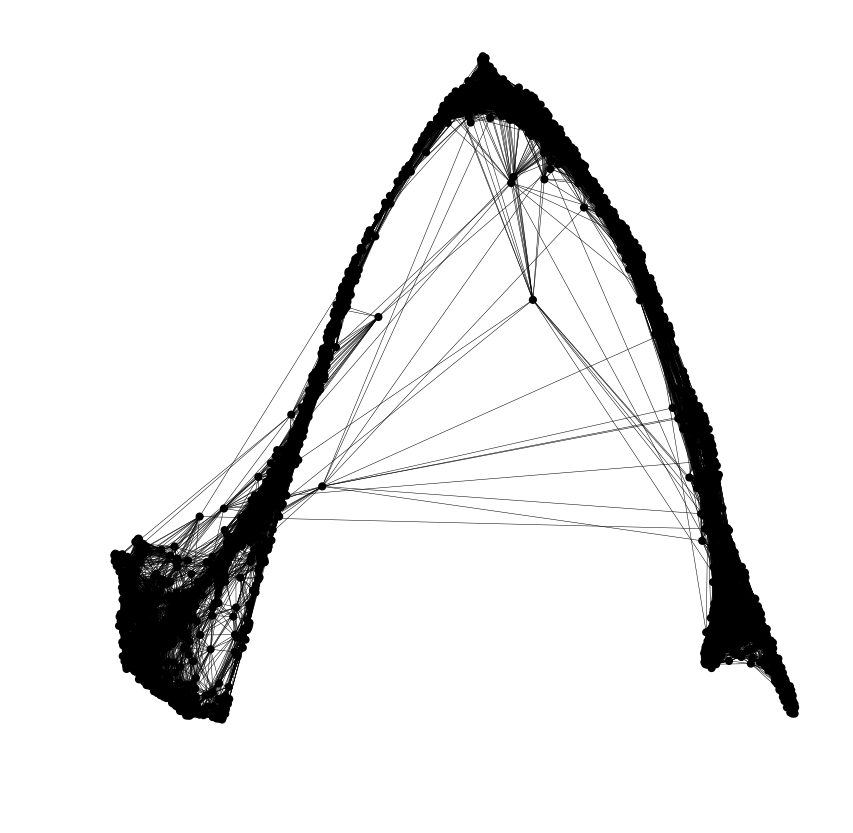

In [24]:
# Plot the ForceAtlas2 graph
sc.pl.draw_graph(mmE95_df_sub, color='library_id', palette=[(0,0,0)], size=24, edges=True, frameon=False, 
                 edges_color='black', edges_width=0.15, legend_loc=None, title = '', save='_mmE95sub.png')


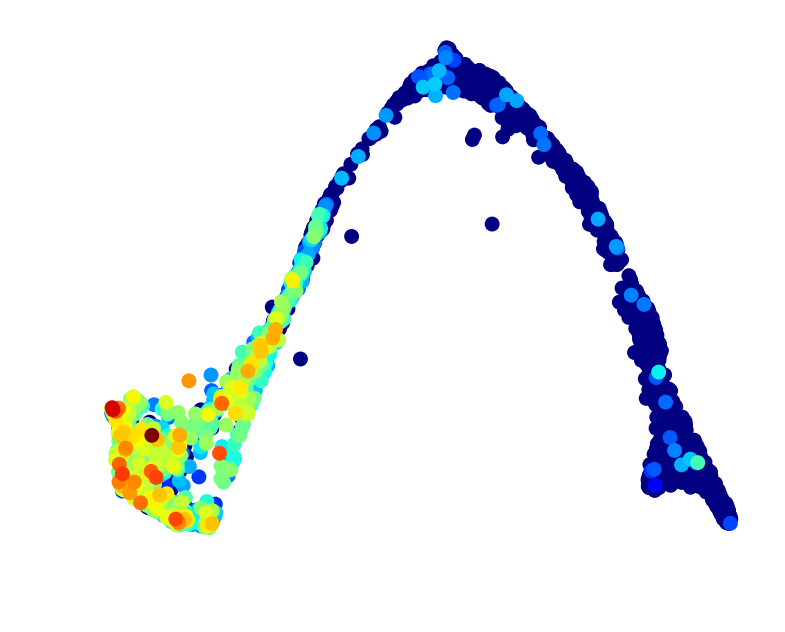

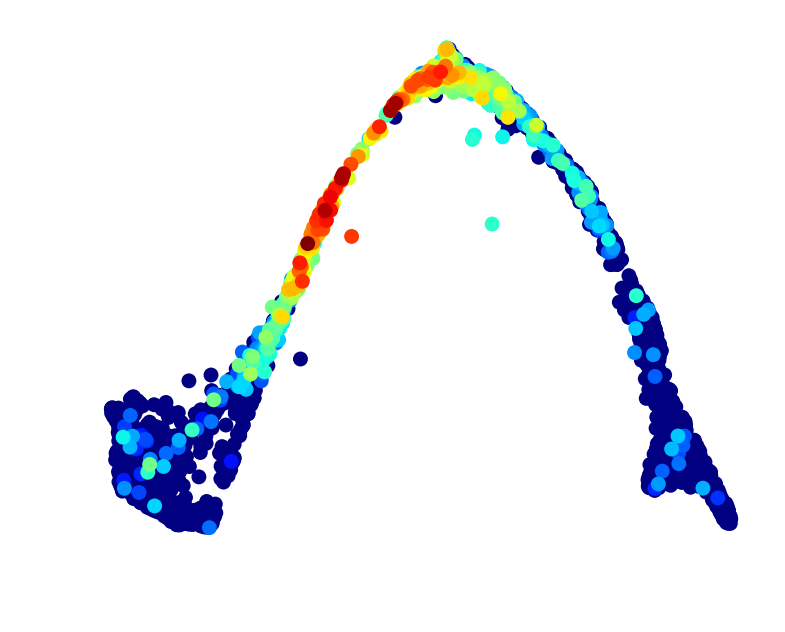

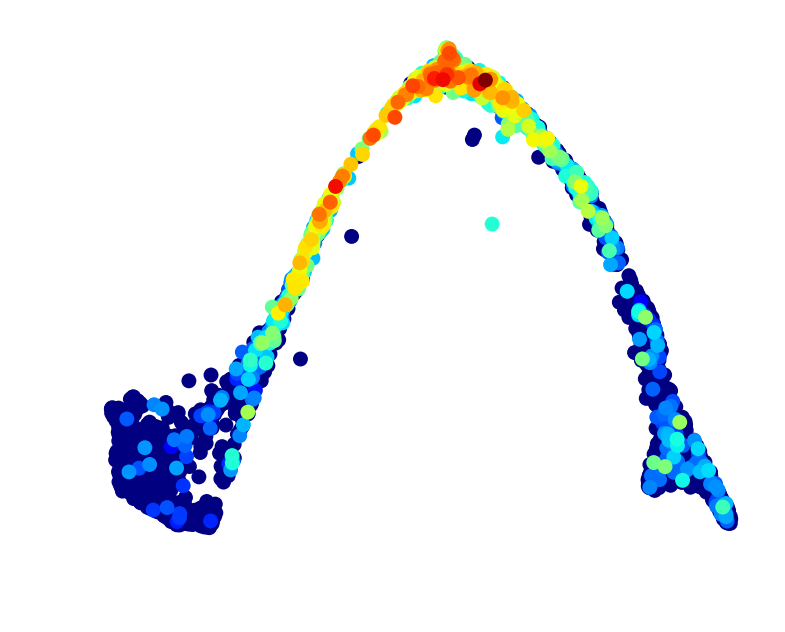

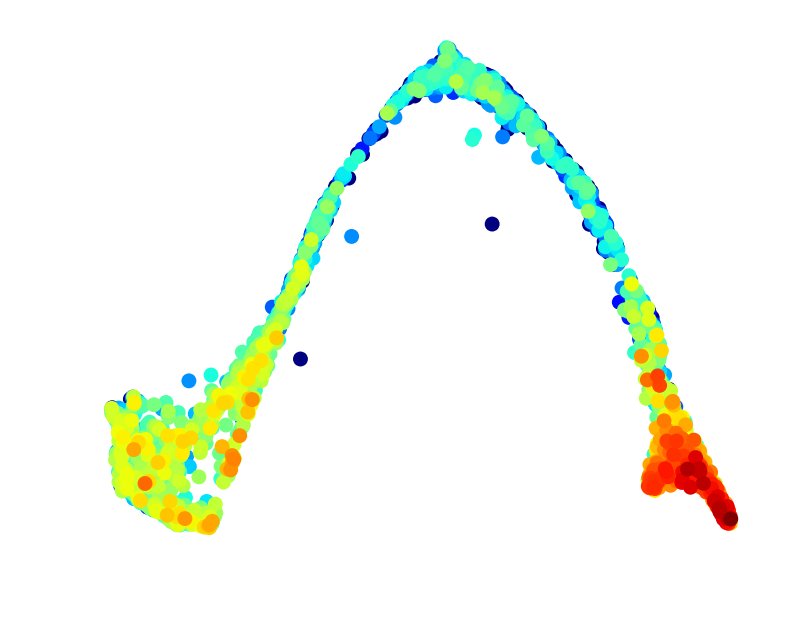

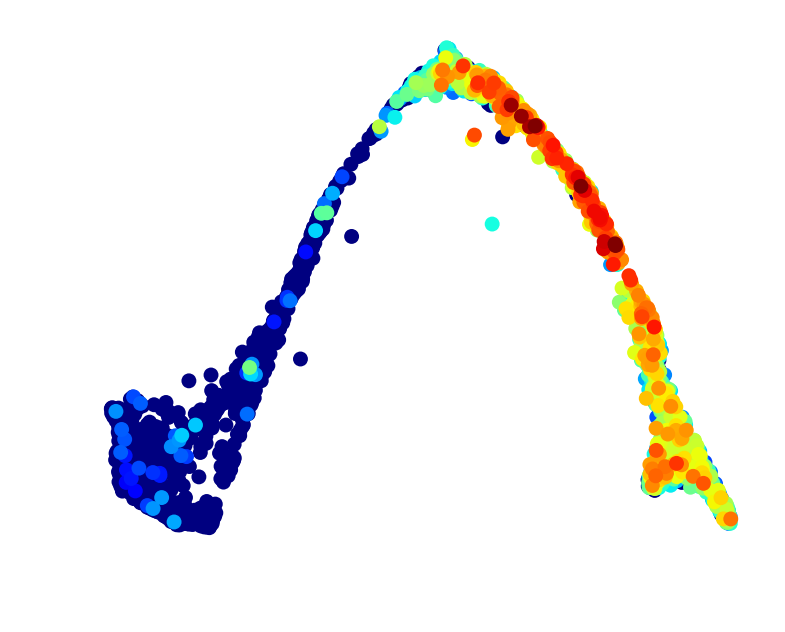

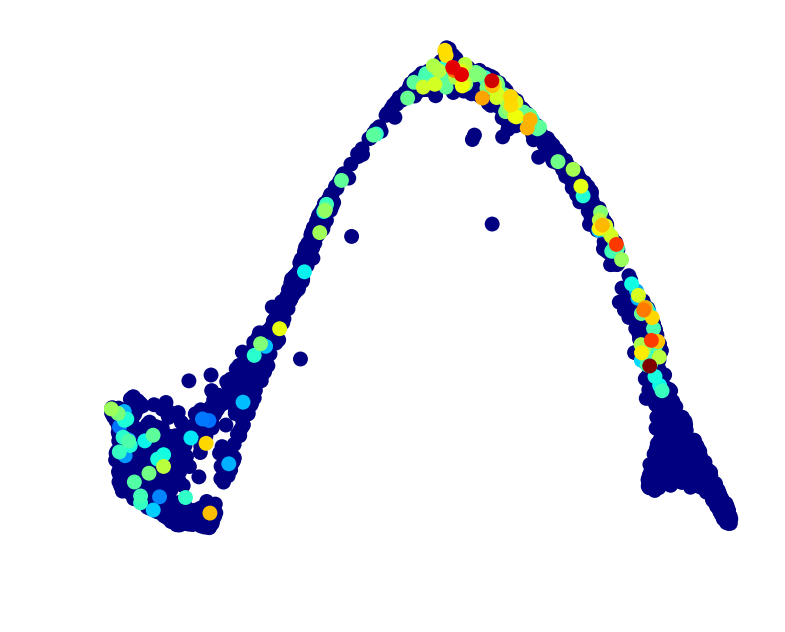

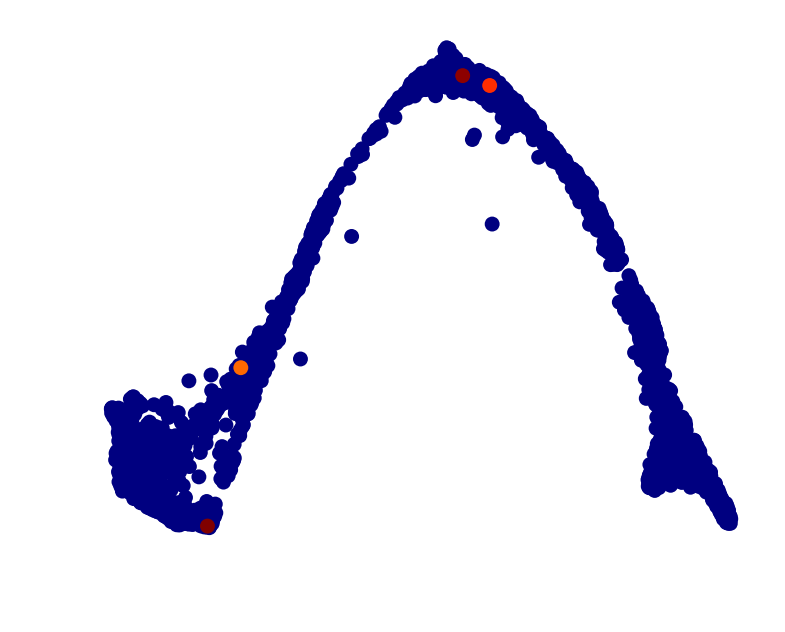

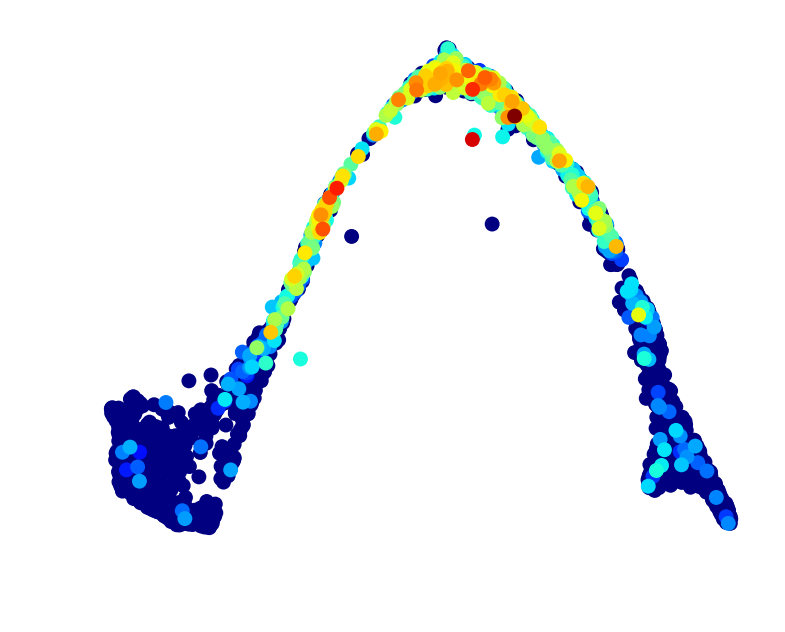

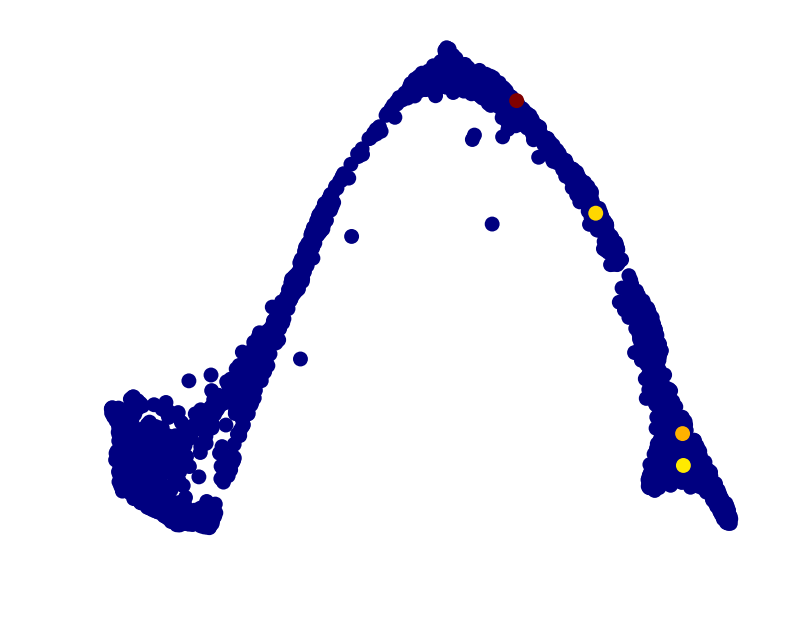

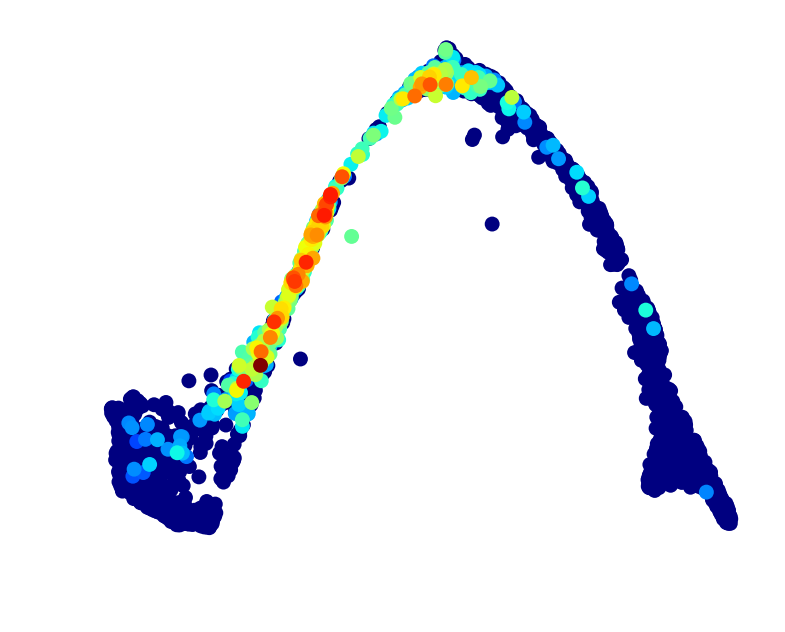

In [25]:
# Overlay gene expression values
genes = ['Sox2','T','Rspo3','Mest','Foxc1', 'Lfng', 'Fgf5', 'Hes7', 'Nodal', 'Fgf17']

for gn in genes:
    sc.pl.draw_graph(mmE95_df_sub, size=80, use_raw=False, color=[gn], edges=False, frameon=False, legend_loc='None',
                     legend_fontsize=10, legend_fontweight='bold', cmap='jet', title='', show=False)
    dew.format_axes(eq_aspect=[0], rm_colorbar=True)
    #plt.subplots_adjust(bottom=0, left=0, right=2, top=0.4)
    plt.savefig('figures/draw_graph_fa_mmE95sub_'+gn+'.png', dpi=600, bbox_inches='tight') 

### Perform clustering on the Neural+PSM subset

running Leiden clustering
    finished (0:00:00.35) --> found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.19) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


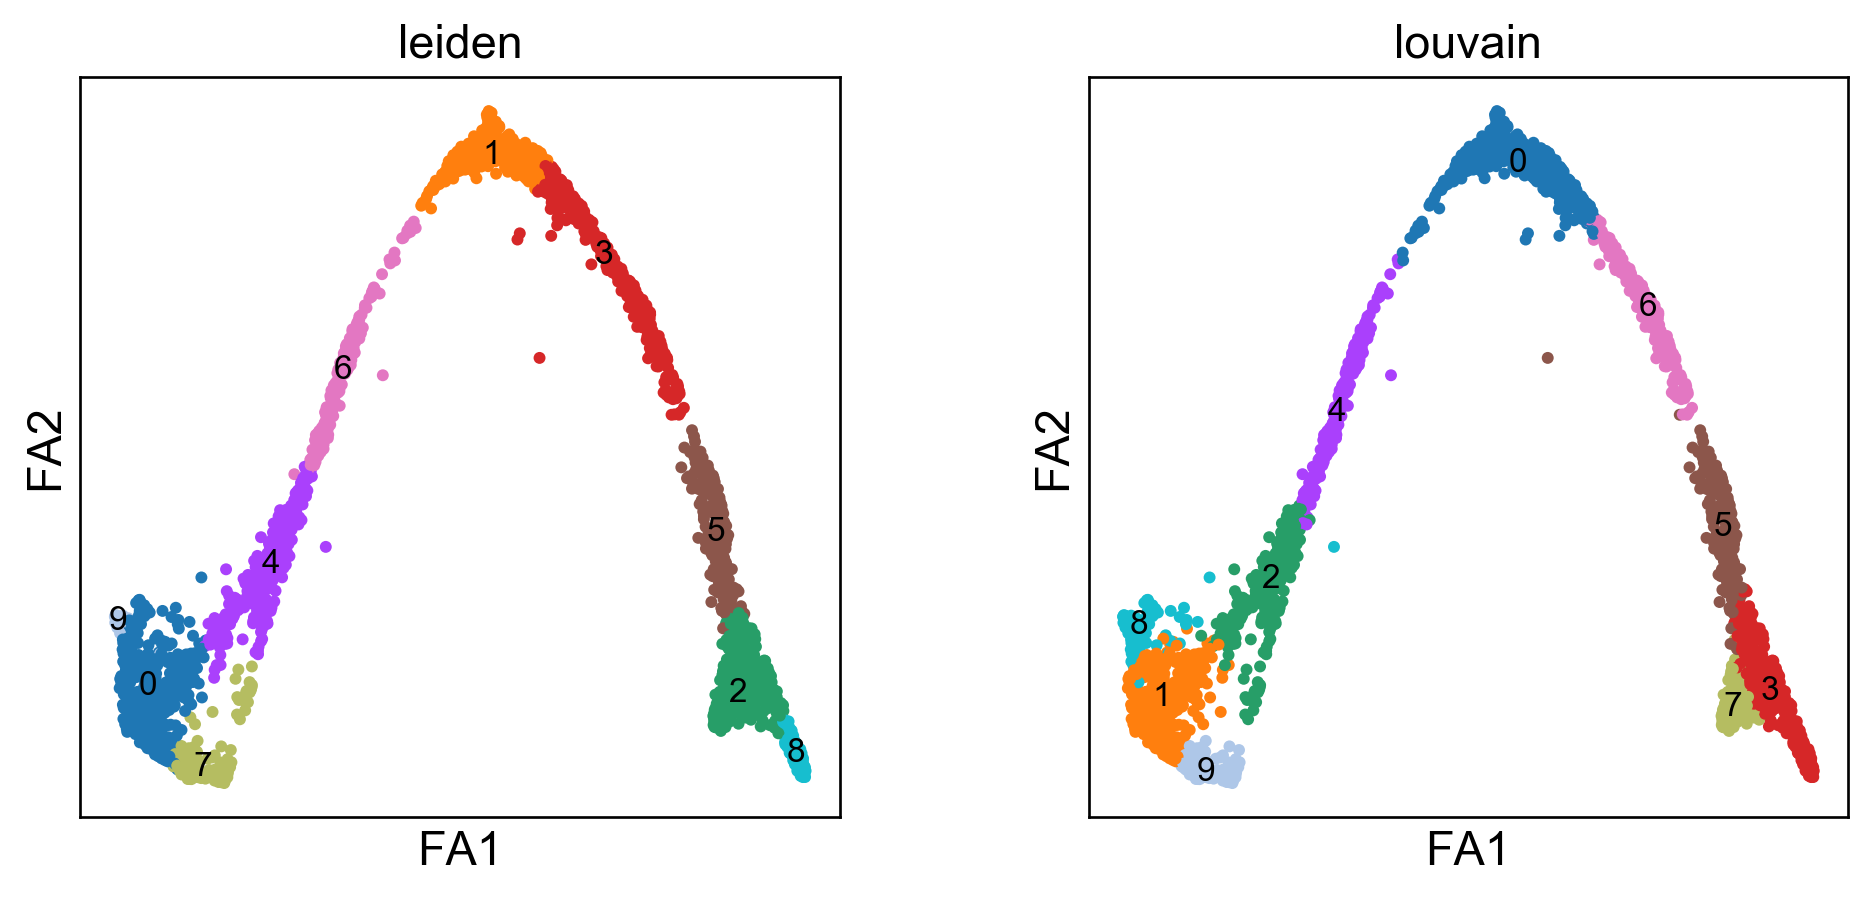

In [26]:
# Perform clustering, overlay on ForceAtlas2 graph
sc.tl.leiden(mmE95_df_sub, resolution=0.6)
sc.tl.louvain(mmE95_df_sub, resolution=1)

sc.pl.draw_graph(mmE95_df_sub, color=['leiden', 'louvain'], edges=False, frameon=True, legend_loc='on data', 
                 legend_fontsize=10, legend_fontweight='medium')

saving figure to file ./figures/draw_graph_fa_mmE95sub_leiden.pdf


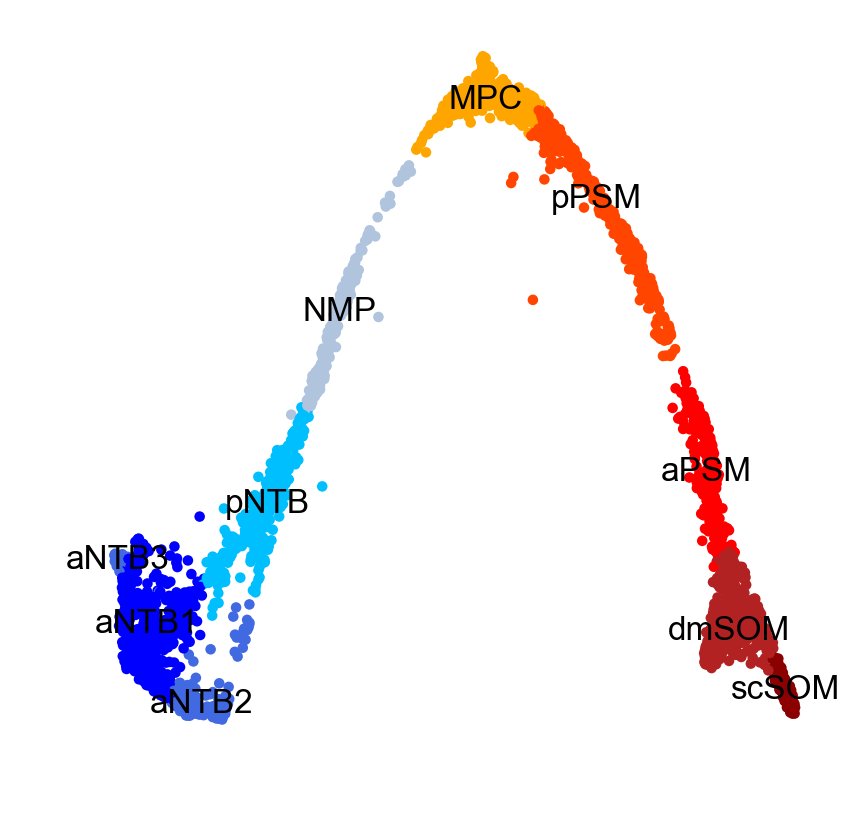

saving figure to file ./figures/draw_graph_fa_mmE95sub_leiden_nolabel.png


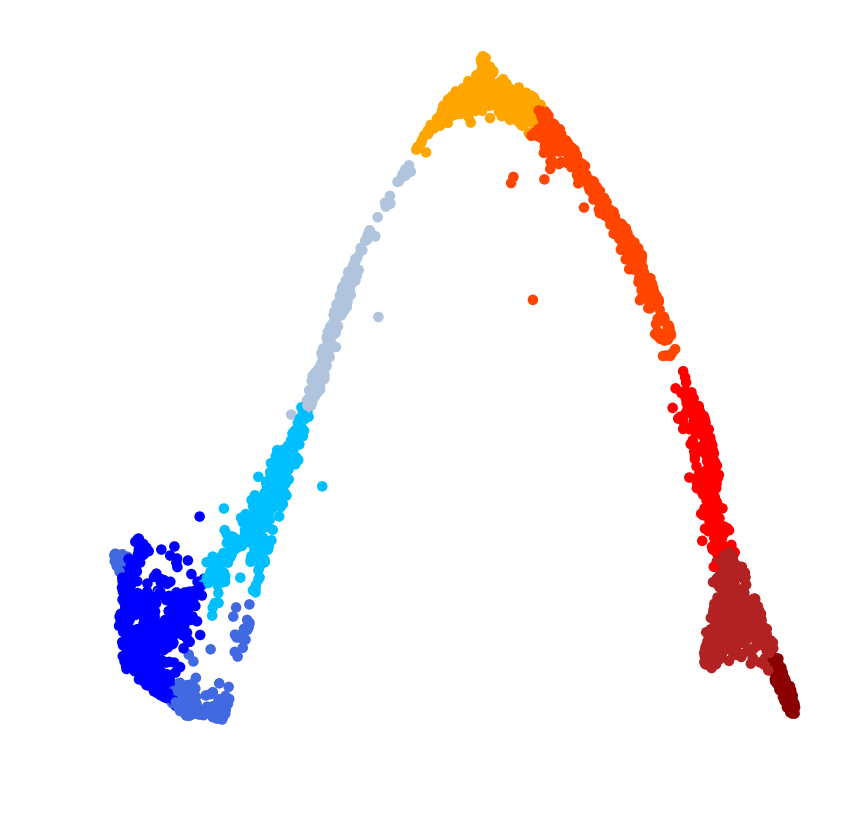

saving figure to file ./figures/draw_graph_fa_mmE95sub_louvain.pdf


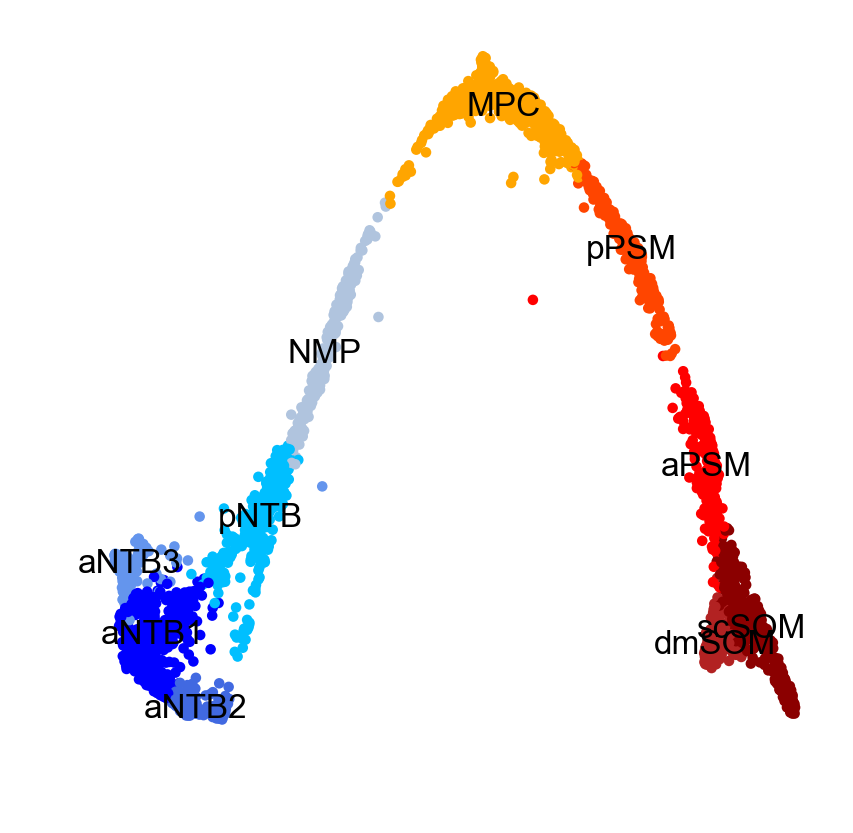

saving figure to file ./figures/draw_graph_fa_mmE95sub_louvain_nolabel.png


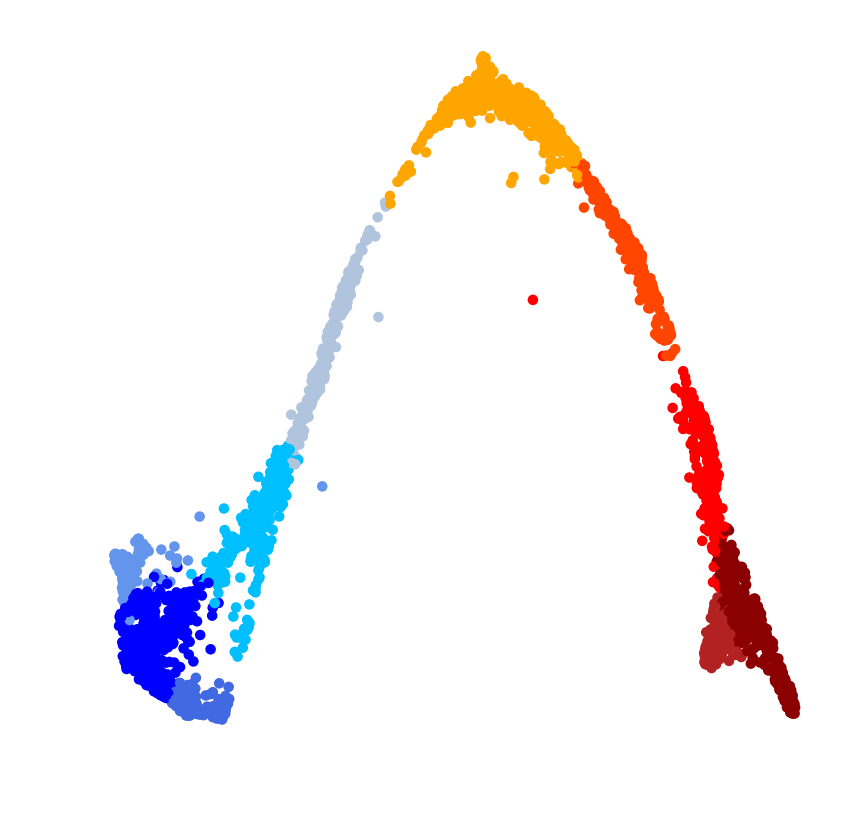

In [27]:
# Manual annotation of cluster names
new_leiden_names = ['aNTB1', 'MPC', 'dmSOM', 'pPSM', 'pNTB', # 0-4
                    'aPSM', 'NMP', 'aNTB2', 'scSOM', 'aNTB3'] # 5-9
new_louvain_names = ['MPC', 'aNTB1', 'pNTB', 'scSOM', 'NMP', # 0-4
                     'aPSM', 'pPSM', 'dmSOM', 'aNTB3', 'aNTB2'] # 5-9
mmE95_df_sub.rename_categories('leiden', new_leiden_names)
mmE95_df_sub.rename_categories('louvain', new_louvain_names)

# Overlay new cluster assignments
sc.pl.draw_graph(mmE95_df_sub, color=['leiden'], palette=['blue','orange','firebrick','orangered','deepskyblue','red','lightsteelblue','royalblue','darkred','royalblue'],
                 size=40, edges=False, frameon=False, title='', legend_loc='on data', 
                 legend_fontsize=10, legend_fontweight='medium',
                 save='_mmE95sub_leiden.pdf')
sc.pl.draw_graph(mmE95_df_sub, color=['leiden'], size=40, edges=False, frameon=False, title='', legend_loc='none', 
                 legend_fontsize=10, legend_fontweight='medium',
                 save='_mmE95sub_leiden_nolabel.png')

sc.pl.draw_graph(mmE95_df_sub, color=['louvain'], palette=['orange','blue','deepskyblue','darkred','lightsteelblue','red','orangered','firebrick','cornflowerblue','royalblue'],
                 size=40, edges=False, frameon=False, title='', legend_loc='on data', 
                 legend_fontsize=10, legend_fontweight='medium',
                 save='_mmE95sub_louvain.pdf')
sc.pl.draw_graph(mmE95_df_sub, color=['louvain'], size=40, edges=False, frameon=False, title='', legend_loc='none', 
                 legend_fontsize=10, legend_fontweight='medium',
                 save='_mmE95sub_louvain_nolabel.png')

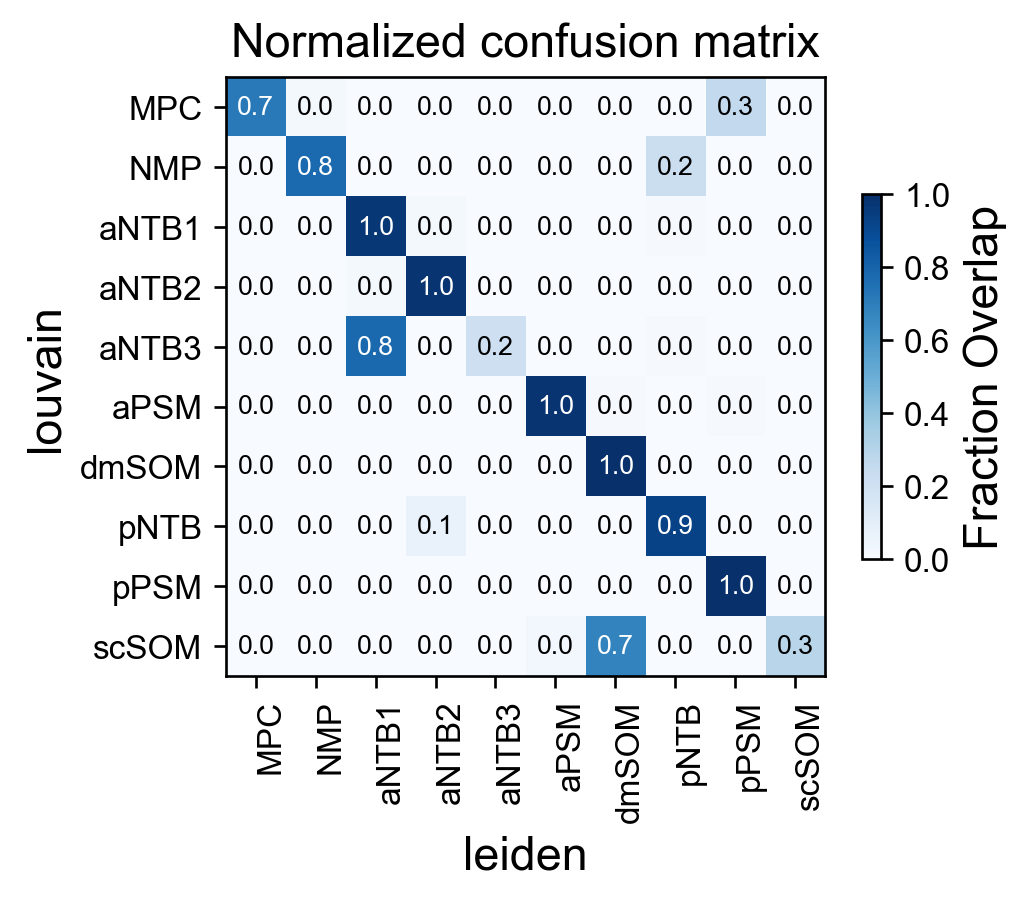

In [28]:
# Plot a confusion matrix to compare clustering assignments
fg,ax = dew.plot_confusion_matrix(mmE95_df_sub.obs['leiden'], mmE95_df_sub.obs['louvain'], normalize=True, overlay_values=True)
fg.savefig('./figures/confmat_mmE95sub_leidenlouvain.png', bbox_inches='tight')


### Get Marker Genes

In [29]:
sc.tl.rank_genes_groups(mmE95_df_sub, 'louvain', use_raw=True, groups='all', reference='rest', n_genes=100, 
                        method='wilcoxon', corr_method='benjamini-hochberg', log_transformed=True)

ranking genes


/Users/dan/Dropbox (HMS)/Code/Git/scanpy/scanpy/tools/_rank_genes_groups.py:380: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[imask]) + 1e-9) / (np.expm1(mean_rest) + 1e-9)  # add small value to remove 0's


    finished (0:00:09.93) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


In [30]:
# Generate a tables of differentially expressed genes for each group
deg = mmE95_df_sub.uns['rank_genes_groups']
groups = deg['names'].dtype.names

# Format a table with top 100 gene names and corrected p-values, export to excel
df_names_pvals = pd.DataFrame({groups+'_'+key: deg[key][groups] for groups in groups for key in ['names','logfoldchanges','pvals']}).head(100)
df_names_pvals.to_excel('tables/mmE95sub_DEGTable.xlsx')

In [31]:
# Print top 20 gene names to screen~
pd.DataFrame({groups : deg[key][groups] for groups in groups for key in ['names']}).head(20)

MPC    aNTB1    pNTB    scSOM      NMP      aPSM     pPSM    dmSOM  \
0     Tpm1    Ccnd2  Slc2a3     Fbn2  Cyp26a1     Meox1     Dll1     Mest   
1     Smc6     Pax6   Mkrn1   Twist1   Slc2a3     Foxc2    Foxc1  Selenop   
2    Rspo3   Slc2a1   Greb1     Mest    Greb1     Tcf15   Pcdh19    Nr2f2   
3     Nkd2   Crabp2   Uchl1     Arg1    Ccnjl      Add3     Dll3    Meox1   
4   Cited1     Sox3    Chd3    Meox1        T      Arg1    Nrarp    Tcf15   
5     Dll3    Sfrp2   Sall4   Cxcl12     Cdx2     Foxp1  Gm14226    Cadm1   
6     Btg2  Fam181b    Sox3    Tcf15    Fgf17      Ntn1      H19    Plch1   
7   Ifitm1      Ptn  Kcnab3    Foxc2   Hoxd11     Cadm1    Foxc2      Fst   
8     Lmo2    Map1b    Sox2  Foxd2os   Pmaip1   Shroom3    Meox1     Arg1   
9    Arl4d     Sox1  Pmaip1   Nkx3-1     Fgf8   Epb41l3      Fn1    Dmrt2   
10    Dll1     Bex4  Slc2a1    Fstl1     Npm3    Pcdh19     Igf2     Pax3   
11    Eogt     Sox2     Id2   Marcks     Evx1      Fbn2    Ddit4     Gas1   
12   Sept8     Bex1  Plagl1    Foxd1     Ptk7    Notch1    Smoc1    Flrt3   
13     Fn1    Apela  Hoxc10     Ets1    Wnt5a    Cxcl12     Hey1    Epha7   
14    Lef1     Irx1     Nin   Phlda1      Oat       H19     Zic3     Fbn2   
15  Hoxd11     Utrn    Zic5    Cdh11   Arid3b  Slc9a3r1     Lmo4     Ntn1   
16    Tbx6     Odc1   Syt11  Col26a1    Dusp6     Fgfr1     Lef1   Phlda1   
17    Hes7     Irx5  Jarid2    Foxd2   Hoxc10    Cited2    Pcdh8     Eya1   
18   Snai1   Tubb2b  Igfbp2     Ntn1   Evx1os     Foxc1   Cxcl12  Col26a1   
19   Nrarp  Fam181a     Oat      H19     Lix1     Efnb2   Cited2   Col4a1   

       aNTB3    aNTB2  
0     Nkx6-1     Zic1  
1      Ccnd2     Msx1  
2   Trp53i11      Ptn  
3      Olig2   Crabp2  
4       Sox2      Id3  
5       Sox3    Fgfr2  
6     Slc2a1     Sox2  
7     Crabp2     Pax3  
8       Utrn     Gas1  
9      Map1b    Ccnd1  
10     Apela     Bex4  
11     Ptch1      Id2  
12      Prtg     Prtg  
13      Hes5   Slc2a1  
14    Igfbp5     Msx3  
15    Pou3f2    Hspa8  
16      Cib1  Fam181b  
17   Fam181b   Zfand5  
18     Spon1    Podxl  
19     Timp3    Ddx39

In [40]:
# Print number of cells in each cluster
nTotalCells = len(mmE95_df_sub.obs)
for name in np.unique(mmE95_df_sub.obs['louvain']):
    nCells = sum(mmE95_df_sub.obs['louvain'].isin([name]))
    fCells = nCells / nTotalCells * 100            
    print(name + ': ' + str(nCells))
print('Total nCells: ' + str(nTotalCells))

MPC: 479
NMP: 227
aNTB1: 360
aNTB2: 93
aNTB3: 99
aPSM: 198
dmSOM: 151
pNTB: 278
pPSM: 187
scSOM: 268
Total nCells: 2340


### Compute Trajectories through the Neural+PSM subgraph

running PAGA
    finished (0:00:00.11) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_mmE95sub_louvain.pdf


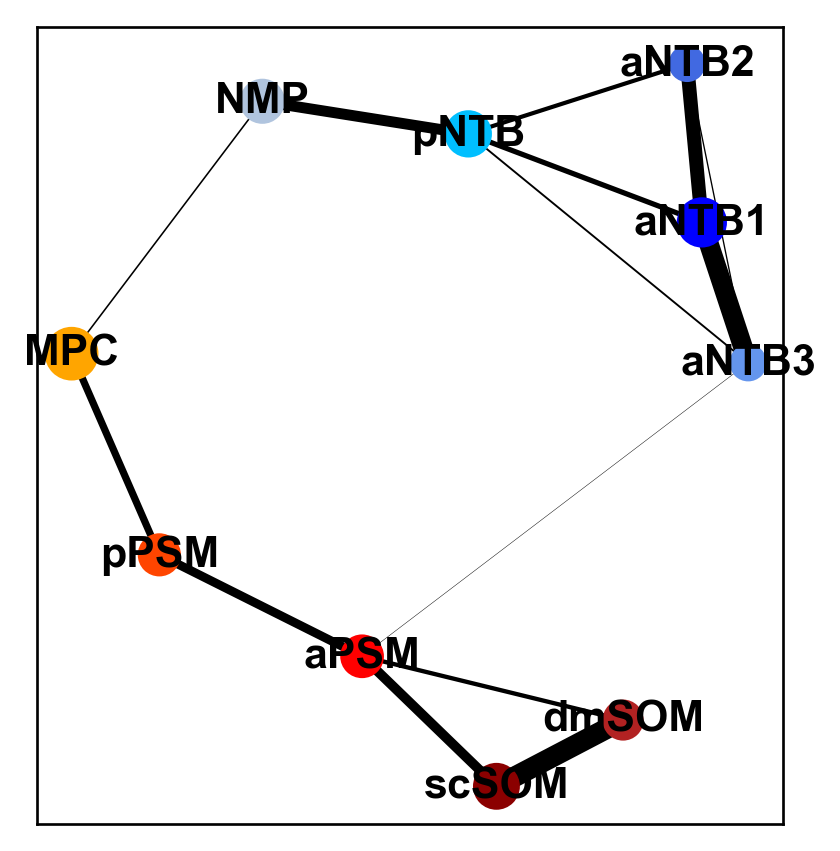

--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_compare_mmE95sub_louvain.pdf


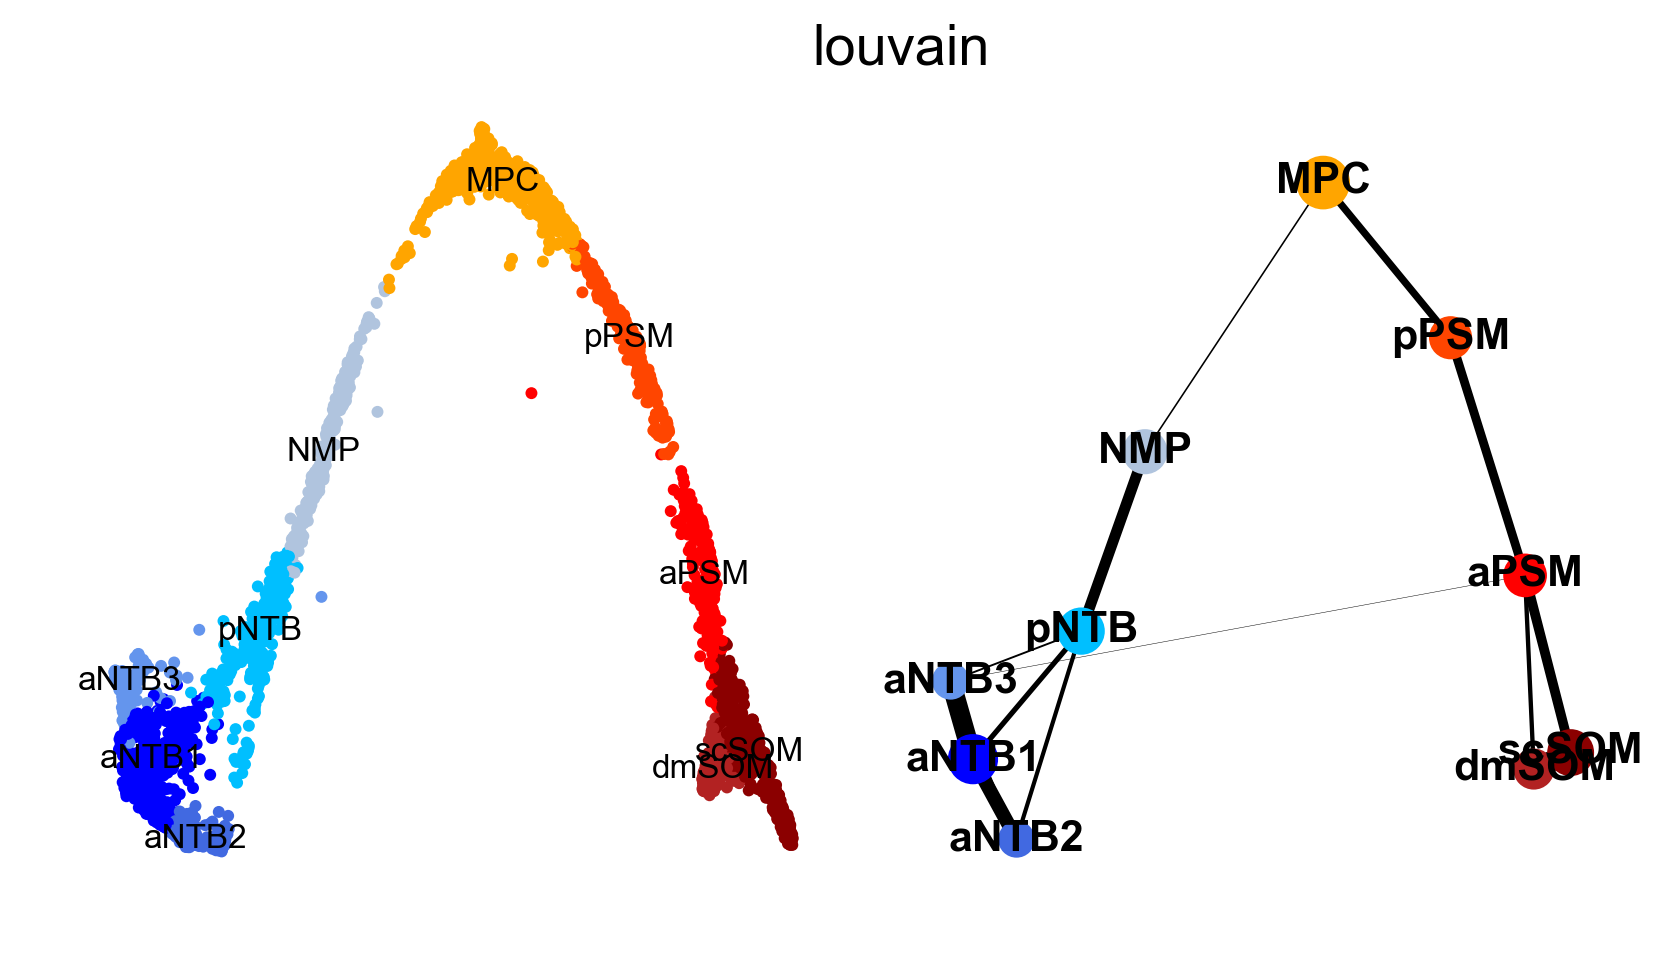

In [32]:
# Get PAGA graph
sc.tl.paga(mmE95_df_sub, groups='louvain')
sc.pl.paga(mmE95_df_sub, threshold=0.01, edge_width_scale=1, save='_mmE95sub_louvain.pdf')

sc.pl.paga_compare(mmE95_df_sub, threshold=0.01, edge_width_scale=1,                  
                   legend_fontsize=10, legend_fontweight='medium',
                   save='_mmE95sub_louvain.pdf')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.99818456 0.9949419  0.9872399  0.9803892  0.9715593
     0.9700178  0.9680869  0.9585476  0.9511313  0.93791986 0.9335849
     0.9266557  0.9189804  0.9143766 ]
    finished (0:00:00.06) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.00) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


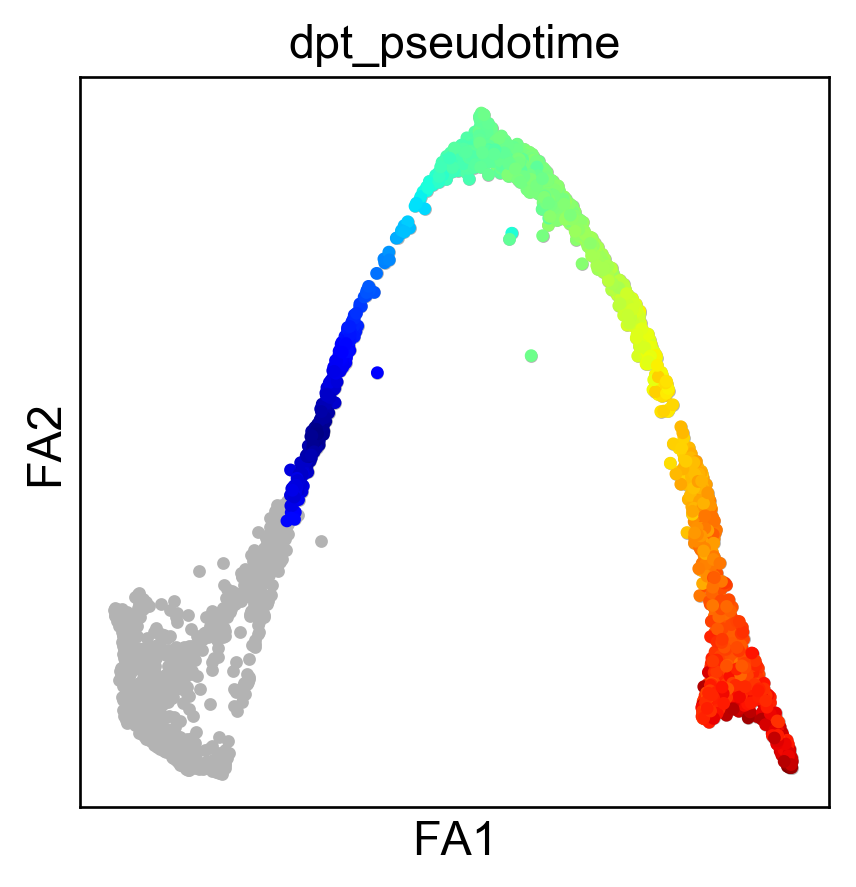

In [33]:
# Calculate dpt pseudotime, starting from the NMP cluster
mmE95_df_sub.uns['iroot'] = np.flatnonzero(mmE95_df_sub.obs['leiden']  == 'NMP')[0]
sc.tl.diffmap(mmE95_df_sub)
sc.tl.dpt(mmE95_df_sub)

# Plot DPT values just for the NMP->SOM path
PMflag = mmE95_df_sub.obs['louvain'].isin(['NMP','pPSM','aPSM','dmSOM','MPC','scSOM'])
fig,ax =plt.subplots(figsize=(4,4))
ax.scatter(mmE95_df_sub.obsm['X_draw_graph_fa'][:,0], mmE95_df_sub.obsm['X_draw_graph_fa'][:,1], c=[.7,.7,.7], s=8)
ax.scatter(mmE95_df_sub.obsm['X_draw_graph_fa'][:,0][PMflag], mmE95_df_sub.obsm['X_draw_graph_fa'][:,1][PMflag], 
           c=mmE95_df_sub.obs['dpt_pseudotime'][PMflag], cmap='jet', s=8)
ax.set_xticks([]); ax.set_yticks([]);
ax.set_xlabel('FA1'); ax.set_ylabel('FA2'); ax.set_title('dpt_pseudotime')
fig.savefig('./figures/draw_graph_fa_mmE95sub_dpt.png', bbox_inches='tight')

### Identify Dynamically Expressed Genes

In [34]:
# Subset the raw counts data for PM trajectory cells
PMflag = mmE95_df_sub.obs['louvain'].isin(['NMP','pPSM','aPSM','dmSOM','MPC','scSOM'])
mmE95_df_subsub = mmE95_df_sub[PMflag,:]
mmE95_df_subsub.X = mmE95_df_subsub.raw.X

# Flag genes based on minimum expression
gene_expressed_flag = np.squeeze(np.asarray(np.sum(mmE95_df_subsub.X >= 1, axis=0) >= 20))

# Basic preprocessing
sc.pp.normalize_total(mmE95_df_subsub)
sc.pp.log1p(mmE95_df_subsub)

# Subset genes
mmE95_df_subsub = mmE95_df_subsub[:,gene_expressed_flag]

# Get dynamic genes, save to excel file
mmE95_df_subsub = dew.get_dynamic_genes(mmE95_df_subsub, sliding_window=100, fdr_alpha = 0.05)
dyn_genes = mmE95_df_subsub.var[mmE95_df_subsub.var['dyn_fdr_flag']].sort_values(by=['dyn_peak_cell'])
dyn_genes['dyn_gene_ord']=[ind for ind in range(1,len(dyn_genes)+1)]
dyn_genes[['dyn_fdr','dyn_peak_cell','dyn_gene_ord']].to_excel('tables/mmE95sub_DYNTable.xlsx')

done calculating p-values
done calculating randomized p-values
done calculating fdr


### Plot Gene Expression Trajectories

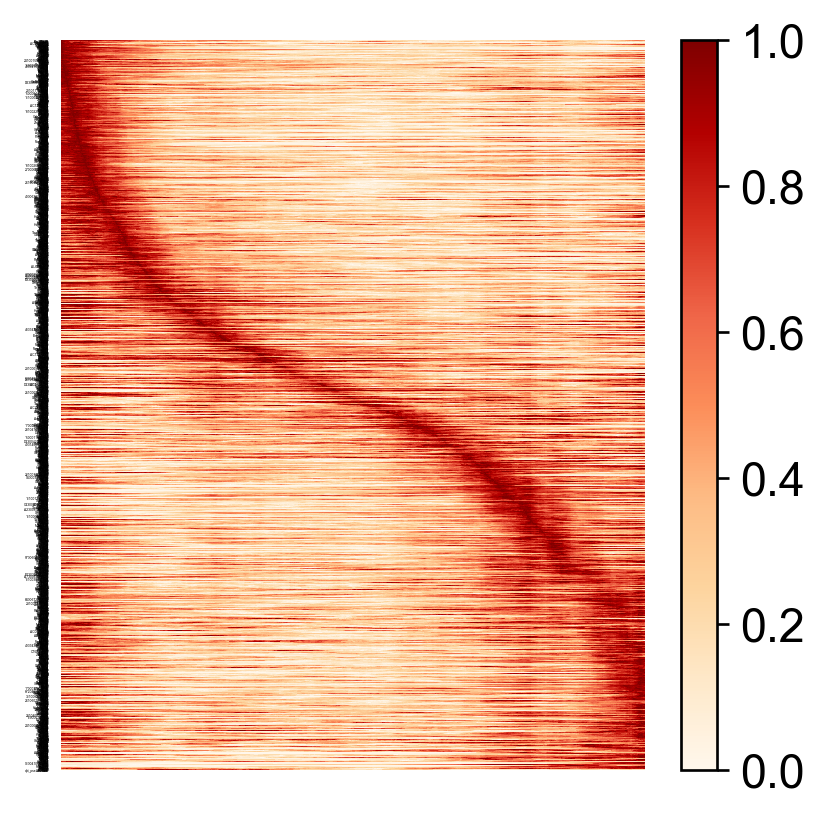

In [35]:
# Plot gene expression trajectories for all dynamic genes
traj_nodes = ['NMP','MPC','pPSM','aPSM','dmSOM']

ax = sc.pl.paga_path(mmE95_df_sub, nodes=traj_nodes, keys=dyn_genes.index, use_raw=True, annotations=['dpt_pseudotime'],
                     color_map='OrRd', color_maps_annotations={'dpt_pseudotime': 'jet'}, palette_groups=None, 
                     n_avg=100, groups_key=None, xlim=[None, None], title=None, left_margin=None, ytick_fontsize=1, 
                     title_fontsize=None, show_node_names=False, show_yticks=True, show_colorbar=True, 
                     legend_fontsize=1, legend_fontweight=None, normalize_to_zero_one=True, as_heatmap=True, 
                     return_data=False, show=False, ax=None)
plt.savefig('figures/paga_path_dynamic_genes.png', dpi=2000, bbox_inches='tight')


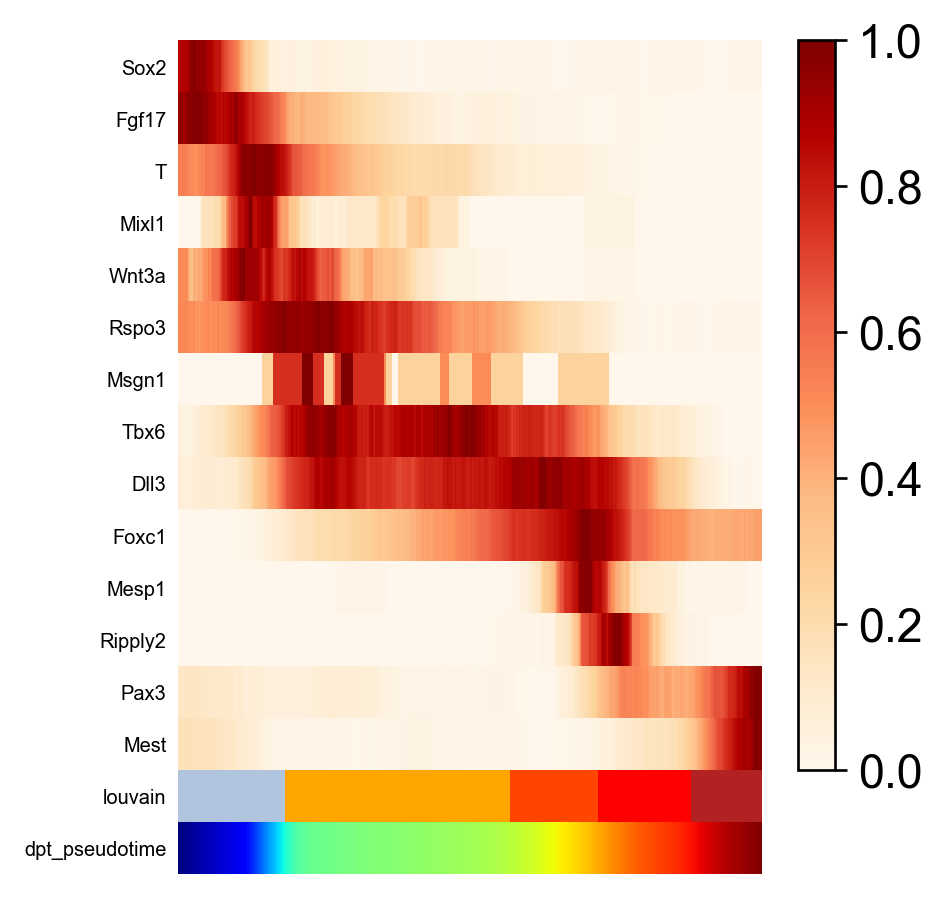

In [36]:
# Plot gene expression trajectories for select markers
traj_nodes = ['NMP','MPC','pPSM','aPSM','dmSOM']
traj_genes = ['Sox2','Fgf17','T','Mixl1','Wnt3a','Rspo3','Msgn1','Tbx6','Dll3','Foxc1','Mesp1','Ripply2','Pax3','Mest']

ax = sc.pl.paga_path(mmE95_df_sub, nodes=traj_nodes, keys=traj_genes, use_raw=True, annotations=['dpt_pseudotime'],
                     color_map='OrRd', color_maps_annotations={'dpt_pseudotime': 'jet'}, palette_groups=None, 
                     n_avg=100, groups_key=None, xlim=[None, None], title=None, left_margin=None, ytick_fontsize=6, 
                     title_fontsize=None, show_node_names=False, show_yticks=True, show_colorbar=True, 
                     legend_fontsize=1, legend_fontweight=None, normalize_to_zero_one=True, as_heatmap=True, 
                     return_data=False, show=False, ax=None)
plt.savefig('figures/paga_path_markers.png', dpi=2000, bbox_inches='tight')


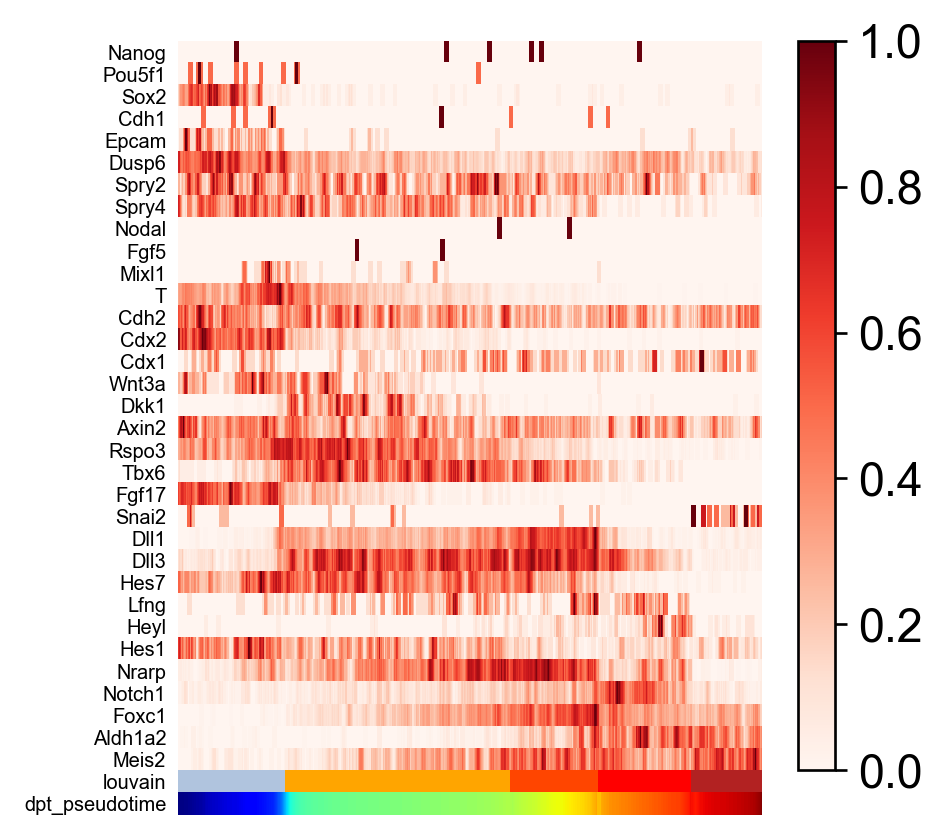

In [37]:
# Plot gene expression trajectories for select markers (supplement)
mouse_markers=['Nanog','Pou5f1','Sox2','Cdh1','Epcam','Dusp6','Spry2','Spry4','Nodal','Fgf5','Mixl1','T','Cdh2','Cdx2','Cdx1','Wnt3a','Dkk1','Axin2','Rspo3','Tbx6','Fgf17','Snai2','Dll1','Dll3','Hes7','Lfng','Heyl','Hes1','Nrarp','Notch1','Foxc1','Aldh1a2','Meis2']
ax = sc.pl.paga_path(mmE95_df_sub, nodes=traj_nodes, keys=mouse_markers, use_raw=True, annotations=['dpt_pseudotime'],
                     color_map='Reds', color_maps_annotations={'dpt_pseudotime': 'jet'}, palette_groups=None, 
                     n_avg=10, groups_key=None, xlim=[None, None], title=None, left_margin=None, ytick_fontsize=6, 
                     title_fontsize=None, show_node_names=False, show_yticks=True, show_colorbar=True, 
                     legend_fontsize=1, legend_fontweight=None, normalize_to_zero_one=True, as_heatmap=True, 
                     return_data=False, show=False, ax=None)
plt.savefig('figures/paga_path_markers_supp.png', dpi=2000, bbox_inches='tight')



### ________________________
  
  

### Save Fully Analyzed DataSets

In [38]:
# Pre-doublet filtering
mmE95.obs.to_csv('Diaz2019_mmE95_obs.csv')
mmE95.write('Diaz2019_mmE95.h5ad')

# Doublet-filtered
mmE95_df.obs.to_csv('Diaz2019_mmE95df_obs.csv')
mmE95_df.write('Diaz2019_mmE95df.h5ad')

# PSM / Neural subset
mmE95_df_sub.obs.to_csv('Diaz2019_mmE95dfsub_obs.csv')
mmE95_df_sub.write('Diaz2019_mmE95dfsub.h5ad')

### Load Fully Analyzed DataSets

In [ ]:
# Load Pre-doublet filtering
mmE95 = sc.read('Diaz2019_mmE95.h5ad')
print(mmE95)

# Doublet-filtered
mmE95_df = sc.read('Diaz2019_mmE95df.h5ad')
print(mmE95_df)

# PSM / Neural subset
mmE95_df_sub = sc.read('Diaz2019_mmE95dfsub.h5ad')
print(mmE95_df_sub)

### ________________________
  
  

### Generate SPRING Plots

In [ ]:
# Export the full Mouse E9.5 dataset
mmE95_df.obsm['X_forSPRING']=mmE95_df.obsm['X_tsne']
mmE95_df.obsm['X_forSPRING'][:,1]=-1*mmE95_df.obsm['X_forSPRING'][:,1] # Flip the y-axis for compatibility with SPRING

sc.external.exporting.spring_project(mmE95_df, 'mmE95_SPRING', 'X_forSPRING', subplot_name='full', 
                                cell_groupings=['louvain','library_id'], custom_color_tracks=['n_counts','n_genes'], 
                                total_counts_key='n_counts', overwrite=True)


In [ ]:
# Export the PSM/Neural subgraph
# Flip the y-axis for compatibility with SPRING
mmE95_df_sub.obsm['X_forSPRING']=mmE95_df_sub.obsm['X_draw_graph_fa']
mmE95_df_sub.obsm['X_forSPRING'][:,1]=-1*mmE95_df_sub.obsm['X_forSPRING'][:,1]

sc.external.exporting.spring_project(mmE95_df_sub, 'mmE95PM_SPRING', 'X_forSPRING', subplot_name='full', 
                                cell_groupings=['louvain','leiden','library_id'], custom_color_tracks=['n_counts','n_genes','dpt_pseudotime'], 
                                total_counts_key='n_counts', overwrite=True)
